# **Chapter 12**
## *Forecasting Using Supervised Machine Learning*, 

This chapter will take you from classical time series forecasting techniques to more advanced machine learning algorithms. The chapter shows how time series data can be transformed appropriately to be suitable for supervised machine learning. In addition, you will explore a variety of machine learning algorithms and implement multi-step forecasting, using both `scikit-learn` and `sktime`.


In this chapter, we will cover the following recipes:
* Preparing time series data for supervised learning
* One-step forecasting using linear regression models with scikit-learn
* Multi-step forecasting using linear regression models with scikit-learn
* Forecasting using non-linear models with sktime
* Optimizing a forecasting model with hyperparameter tuning
* Forecasting with exogenous variables and ensemble learning



# Technical Requirements

If you need a quick refresher on creating a virtual Python environment, check out the *Development environment setup* recipe, from **Chapter 1**, *Getting Started with Time Series Analysis*. The chapter covers two methods: using `conda` and `venv`.   

The following instructions will show how to create a virtual environment using conda. You can call the environment any name you like. For the following example, we will name the environment sktime: 

```
conda create -n sktime python=3.9 -y
conda activate sktime
conda install -c conda-forge sktime-all-extras
```
To make the new sktime environment visible within Jupyter, you can run the following code:

```
python -m ipykernel install —user —name sktime —display-name "sktime"
```

* To install using `pip`, run the following command:
```
pip install "sktime[all_extras]"
```


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')



In [3]:
import sktime
import statsmodels as sm
import matplotlib 
import sklearn

print(f'''
sktime ->  {sktime.__version__}
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
sklearn -> {sklearn.__version__}
statsmodels -> {sm.__version__}
''')


sktime ->  0.22.0
Matplotlib -> 3.6.2
pandas -> 1.5.2   
numpy -> 1.23.5
sklearn -> 1.1.3
statsmodels -> 0.13.5



In [4]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [14, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [5]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)

In [6]:
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [7]:
def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [8]:
class Standardize:
    def __init__(self, split=0.15):
        self.split = split
    
    def _transform(self, df):
        return (df - self.mu)/self.sigma
    
    def split_data(self, df):
        n = int(len(df) * test_split)
        train, test = df[:-n], df[-n:]
        return train, test
    
    def fit_transform(self, train, test):
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s =  self._transform(test)
        return train_s, test_s

    def transform(self, df):
        return self._transform(df)
    
    def inverse(self, df):
        return (df * self.sigma)+self.mu
        
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]

In [9]:
def train_model(train, test, regressor, reg_name):
    X_train, y_train  = train.drop(columns=['y']), train['y']
    X_test, y_test  = test.drop(columns=['y']), test['y']   

    print(f'training {reg_name} ...')
    
    regressor.fit(X_train, y_train) 
     
    yhat = regressor.predict(X_test)    
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_test, yhat, y_train=y_train)    
    residuals = y_test.values - yhat     
    
    model_metadata = {
        'Model Name': reg_name, 'Model': regressor, 
        'RMSE': rmse_test, 'MAPE': mape_test, 'MASE': mase_test,
        'yhat': yhat, 'resid': residuals, 'actual': y_test.values}

    return model_metadata

In [10]:
def train_different_models(train, test, regressors):
    results = []
    for reg_name, regressor in regressors.items():
        results.append(train_model(train,
                                   test,
                                   regressor,
                                   reg_name))
    return results

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
def plot_results(cols, results, data_name):
    for row in results[cols].iterrows():
        yhat, resid, actual, name = row[1]
        plt.title(f'{data_name} - {name}')
        plt.plot(actual, 'k--', alpha=0.5)
        plt.plot(yhat, 'k')
        plt.legend(['actual', 'forecast'])
        plot_acf(resid, zero=False, 
                 title=f'{data_name} - Autocorrelation')
        plt.show()

In [12]:
from sktime.performance_metrics.forecasting import(MeanAbsolutePercentageError, 
                                                   MeanSquaredError, 
                                                   MeanAbsoluteScaledError)

mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()

In [13]:
path = Path('../datasets/')
daily_temp = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)
daily_temp.columns = ['y']
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']

air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)
air.columns = ['y']

In [14]:
daily_temp.index.freq = 'D'
energy.index.freq = 'MS'
air.index.freq = 'M'

In [15]:
print(daily_temp.index.freq)
print(energy.index.freq)
print(air.index.freq)

<Day>
<MonthBegin>
<MonthEnd>


<AxesSubplot: title={'center': 'Monthly Passengers'}, xlabel='date'>

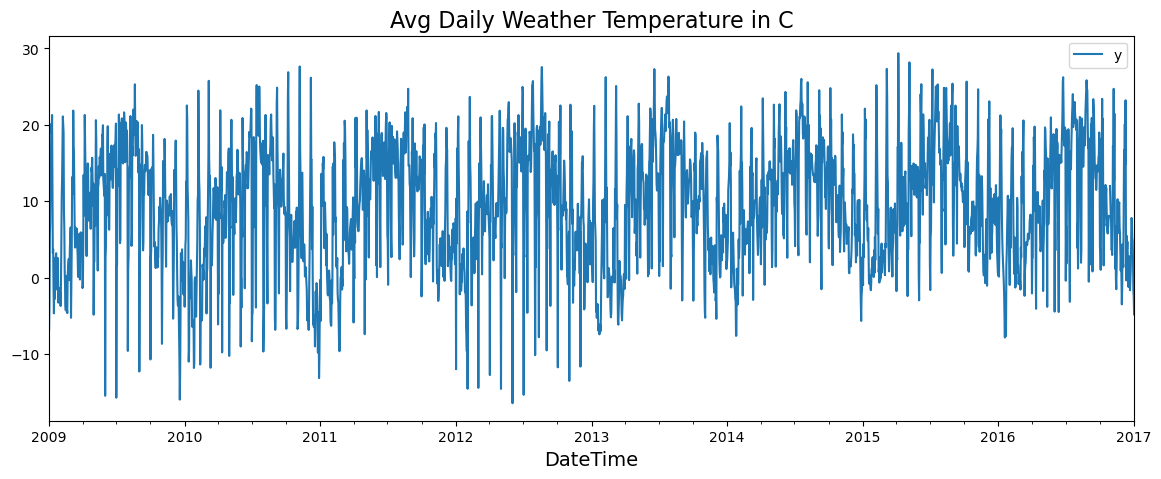

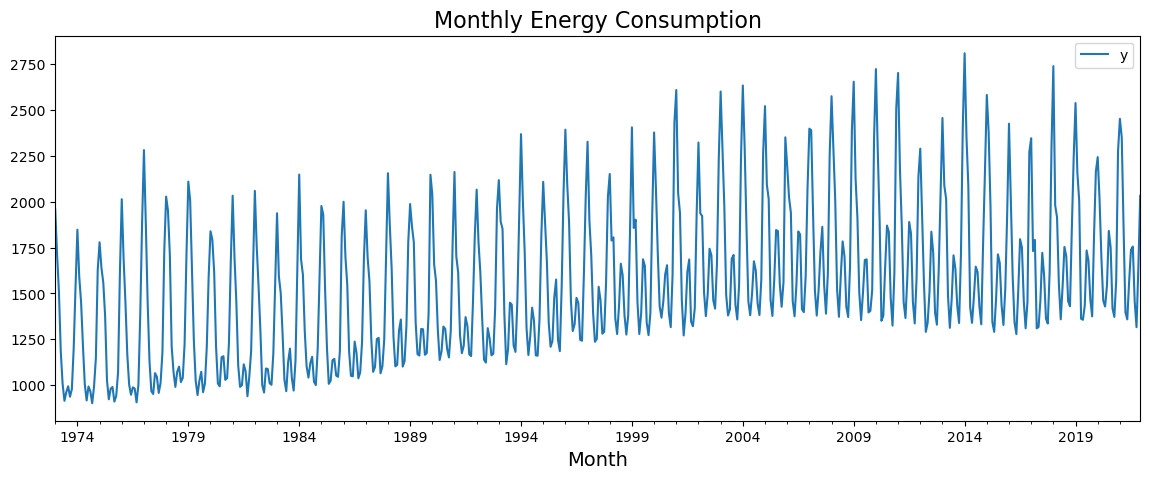

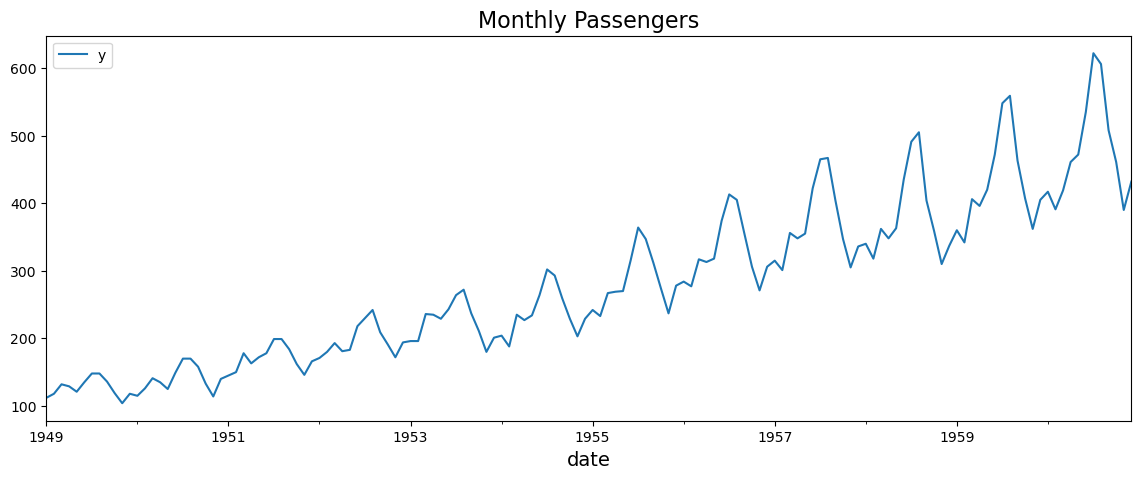

In [16]:
plt.rcParams["figure.figsize"] = [14, 5]  
daily_temp.plot(title='Avg Daily Weather Temperature in C')
energy.plot(title='Monthly Energy Consumption')
air.plot(title='Monthly Passengers')

# Recipe 1. Preparing Time Series Data for Supervised Learning

In [17]:
air_copy = air.copy()
energy_copy = energy.copy()
daily_temp_copy = daily_temp.copy()

In [18]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)

In [19]:
for df in [air_copy, energy_copy, daily_temp_copy]:
    handle_missing_data(df)

found 2 missing observations...


In [20]:
daily_temp_copy.isna().sum()

y    0
dtype: int64

In [21]:
air_os = one_step_forecast(air_copy, 5)
energy_os = one_step_forecast(energy_copy, 5)
daily_temp_os = one_step_forecast(daily_temp_copy, 5)
print(air_os.shape)
print(energy_os.shape)
print(daily_temp_os.shape)

(139, 6)
(583, 6)
(2918, 6)


In [22]:
air_os.head()

x_1  x_2  x_3  x_4  x_5    y
date                                    
1949-01-31  112  118  132  129  121  135
1949-02-28  118  132  129  121  135  148
1949-03-31  132  129  121  135  148  148
1949-04-30  129  121  135  148  148  136
1949-05-31  121  135  148  148  136  119

In [24]:
air_os

x_1  x_2  x_3  x_4  x_5    y
date                                    
1949-01-31  112  118  132  129  121  135
1949-02-28  118  132  129  121  135  148
1949-03-31  132  129  121  135  148  148
1949-04-30  129  121  135  148  148  136
1949-05-31  121  135  148  148  136  119
1949-06-30  135  148  148  136  119  104
1949-07-31  148  148  136  119  104  118
1949-08-31  148  136  119  104  118  115
1949-09-30  136  119  104  118  115  126
1949-10-31  119  104  118  115  126  141
1949-11-30  104  118  115  126  141  135
1949-12-31  118  115  126  141  135  125
1950-01-31  115  126  141  135  125  149
1950-02-28  126  141  135  125  149  170
1950-03-31  141  135  125  149  170  170
1950-04-30  135  125  149  170  170  158
1950-05-31  125  149  170  170  158  133
1950-06-30  149  170  170  158  133  114
1950-07-31  170  170  158  133  114  140
1950-08-31  170  158  133  114  140  145
1950-09-30  158  133  114  140  145  150
1950-10-31  133  114  140  145  150  178
1950-11-30  114  140  145  150  178  163
1950-12-31  140  145  150  178  163  172
1951-01-31  145  150  178  163  172  178
1951-02-28  150  178  163  172  178  199
1951-03-31  178  163  172  178  199  199
1951-04-30  163  172  178  199  199  184
1951-05-31  172  178  199  199  184  162
1951-06-30  178  199  199  184  162  146
1951-07-31  199  199  184  162  146  166
1951-08-31  199  184  162  146  166  171
1951-09-30  184  162  146  166  171  180
1951-10-31  162  146  166  171  180  193
1951-11-30  146  166  171  180  193  181
1951-12-31  166  171  180  193  181  183
1952-01-31  171  180  193  181  183  218
1952-02-29  180  193  181  183  218  230
1952-03-31  193  181  183  218  230  242
1952-04-30  181  183  218  230  242  209
1952-05-31  183  218  230  242  209  191
1952-06-30  218  230  242  209  191  172
1952-07-31  230  242  209  191  172  194
1952-08-31  242  209  191  172  194  196
1952-09-30  209  191  172  194  196  196
1952-10-31  191  172  194  196  196  236
1952-11-30  172  194  196  196  236  235
1952-12-31  194  196  196  236  235  229
1953-01-31  196  196  236  235  229  243
1953-02-28  196  236  235  229  243  264
1953-03-31  236  235  229  243  264  272
1953-04-30  235  229  243  264  272  237
1953-05-31  229  243  264  272  237  211
1953-06-30  243  264  272  237  211  180
1953-07-31  264  272  237  211  180  201
1953-08-31  272  237  211  180  201  204
1953-09-30  237  211  180  201  204  188
1953-10-31  211  180  201  204  188  235
1953-11-30  180  201  204  188  235  227
1953-12-31  201  204  188  235  227  234
1954-01-31  204  188  235  227  234  264
1954-02-28  188  235  227  234  264  302
1954-03-31  235  227  234  264  302  293
1954-04-30  227  234  264  302  293  259
1954-05-31  234  264  302  293  259  229
1954-06-30  264  302  293  259  229  203
1954-07-31  302  293  259  229  203  229
1954-08-31  293  259  229  203  229  242
1954-09-30  259  229  203  229  242  233
1954-10-31  229  203  229  242  233  267
1954-11-30  203  229  242  233  267  269
1954-12-31  229  242  233  267  269  270
1955-01-31  242  233  267  269  270  315
1955-02-28  233  267  269  270  315  364
1955-03-31  267  269  270  315  364  347
1955-04-30  269  270  315  364  347  312
1955-05-31  270  315  364  347  312  274
1955-06-30  315  364  347  312  274  237
1955-07-31  364  347  312  274  237  278
1955-08-31  347  312  274  237  278  284
1955-09-30  312  274  237  278  284  277
1955-10-31  274  237  278  284  277  317
1955-11-30  237  278  284  277  317  313
1955-12-31  278  284  277  317  313  318
1956-01-31  284  277  317  313  318  374
1956-02-29  277  317  313  318  374  413
1956-03-31  317  313  318  374  413  405
1956-04-30  313  318  374  413  405  355
1956-05-31  318  374  413  405  355  306
1956-06-30  374  413  405  355  306  271
1956-07-31  413  405  355  306  271  306
1956-08-31  405  355  306  271  306  315
1956-09-30  355  306  271  306  315  301
1956-10-31  306  271  306  315  301  356
1956-11-30  271  306  315  301  356  348
1956-12-31  306  315  301  356  348

In [26]:
def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [27]:
train, test = split_data(air_os)
print(f'Train: {len(train)} Test: {len(test)}')

Train: 119 Test: 20


In [28]:
scaler = Standardize()
train_s, test_s = scaler.fit_transform(train, test)
train_s.head()

x_1       x_2       x_3       x_4       x_5         y
date                                                                  
1949-01-31 -1.401933 -1.364908 -1.240908 -1.294771 -1.398791 -1.273682
1949-02-28 -1.338755 -1.216817 -1.272708 -1.379791 -1.250613 -1.136238
1949-03-31 -1.191342 -1.248551 -1.357508 -1.231006 -1.113020 -1.136238
1949-04-30 -1.222930 -1.333174 -1.209108 -1.092848 -1.113020 -1.263109
1949-05-31 -1.307167 -1.185083 -1.071309 -1.092848 -1.240029 -1.442843

In [29]:
y_train_original = scaler.inverse_y(train_s['y'])

In [30]:
train_original = scaler.inverse(train_s)
train_original.head()

x_1    x_2    x_3    x_4    x_5      y
date                                                
1949-01-31  112.0  118.0  132.0  129.0  121.0  135.0
1949-02-28  118.0  132.0  129.0  121.0  135.0  148.0
1949-03-31  132.0  129.0  121.0  135.0  148.0  148.0
1949-04-30  129.0  121.0  135.0  148.0  148.0  136.0
1949-05-31  121.0  135.0  148.0  148.0  136.0  119.0

## There is more

In [31]:
df = daily_temp.copy()

In [32]:
df['day_of_week'] = df.index.dayofweek
df['days_in_month'] = df.index.days_in_month
df['month_end'] = df.index.is_month_end.astype(int)
df['is_leap'] = df.index.is_leap_year.astype(int)
df['month'] = df.index.month
df.head()

y  day_of_week  days_in_month  month_end  is_leap  month
DateTime                                                                    
2009-01-01  -6.810629            3             31          0        0      1
2009-01-02  -3.360486            4             31          0        0      1
2009-01-03   5.435694            5             31          0        0      1
2009-01-04   7.283889            6             31          0        0      1
2009-01-05  12.690069            0             31          0        0      1

# Recipe 2. One-Step Forecasting using Linear Regression Models with Scikit-Learn

## How to do it..

In [33]:
from sklearn.linear_model import( LinearRegression, 
                                 ElasticNet, 
                                 Ridge, 
                                 Lasso, 
                                 HuberRegressor)

In [34]:
air_cp = air.copy()
en_cp = energy.copy()
dw_cp = daily_temp.copy()

### Preprocessing Time Series Data

In [35]:
for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)

found 2 missing observations...


In [36]:
air_reg = one_step_forecast(air_cp, 10)
en_reg = one_step_forecast(en_cp, 10)
dw_reg = one_step_forecast(dw_cp, 10)

In [37]:
print(air_reg.shape)
print(en_reg.shape)
print(dw_reg.shape)

(134, 11)
(578, 11)
(2913, 11)


In [38]:
mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()

In [39]:
train_air, test_air = split_data(air_reg, test_split=0.10)
scaler_air = Standardize()
train_air_s, test_air_s = scaler_air.fit_transform(train_air,test_air)

In [40]:
train_en, test_en = split_data(en_reg, test_split=0.10)
scaler_en = Standardize()
train_en_s, test_en_s = scaler_en.fit_transform(train_en, test_en)

In [41]:
train_dw, test_dw = split_data(dw_reg, test_split=0.10)
scaler_dw = Standardize()
train_dw_s, test_dw_s = scaler_dw.fit_transform(train_dw,test_dw)

### Train

In [42]:
regressors = {
    'Linear Regression': LinearRegression(fit_intercept=False),
    'Elastic Net': ElasticNet(0.5, fit_intercept=False),
    'Ridge Regression': Ridge(0.5, fit_intercept=False),
    'Lasso Regression': Lasso(0.5, fit_intercept=False),
    'Huber Regression': HuberRegressor(fit_intercept=False)}

In [43]:
air_results = train_different_models(train_air_s, test_air_s, regressors)
en_results = train_different_models(train_en_s, test_en_s, regressors)
dw_results = train_different_models(train_dw_s, test_dw_s, regressors)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


### Evaluate

In [44]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
air_results = pd.DataFrame(air_results)
air_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
2   Ridge Regression  0.381092  0.202191  1.390807
0  Linear Regression  0.385559  0.205371  1.411072
4   Huber Regression  0.400949  0.214912  1.457932
1        Elastic Net  0.829023  0.328472  2.808737
3   Lasso Regression  1.190006  0.551243  4.439302

In [45]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_results = pd.DataFrame(en_results)
en_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.431651  1.419527  0.525526
2   Ridge Regression  0.433192  1.586383  0.560450
0  Linear Regression  0.433747  1.583406  0.560989
1        Elastic Net  0.747657  1.822362  1.013425
3   Lasso Regression  0.834356  1.548537  1.108092

In [46]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
dw_results = pd.DataFrame(dw_results)
dw_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.655729  1.083826  0.968735
0  Linear Regression  0.646648  1.037424  0.990057
2   Ridge Regression  0.646639  1.037273  0.990085
1        Elastic Net  0.737896  0.913599  1.300792
3   Lasso Regression  0.814609  0.911730  1.468567

#### Air Passengers Plots

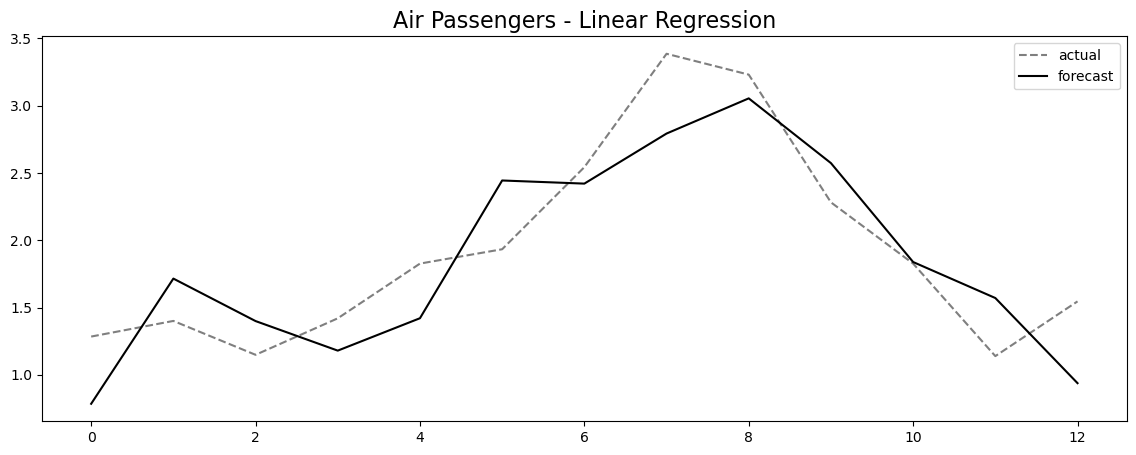

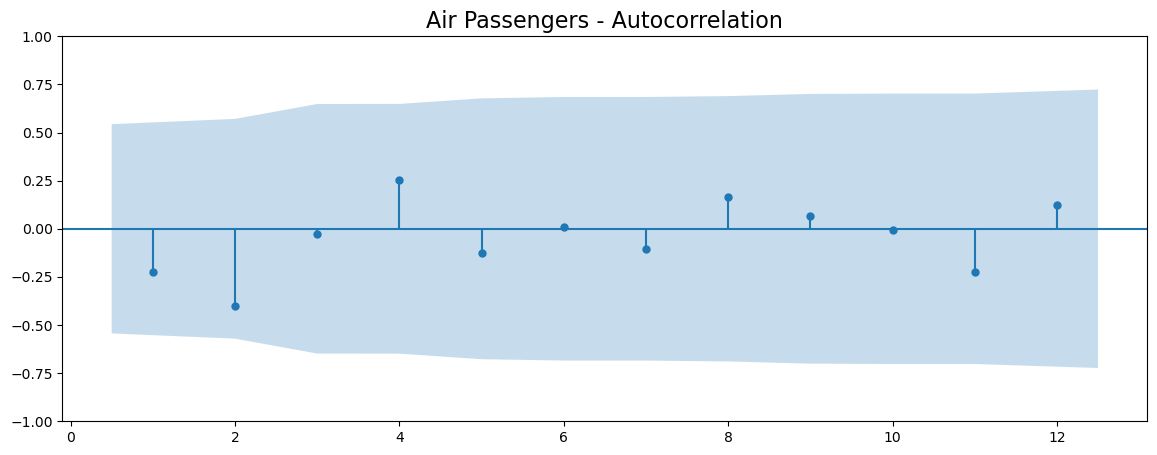

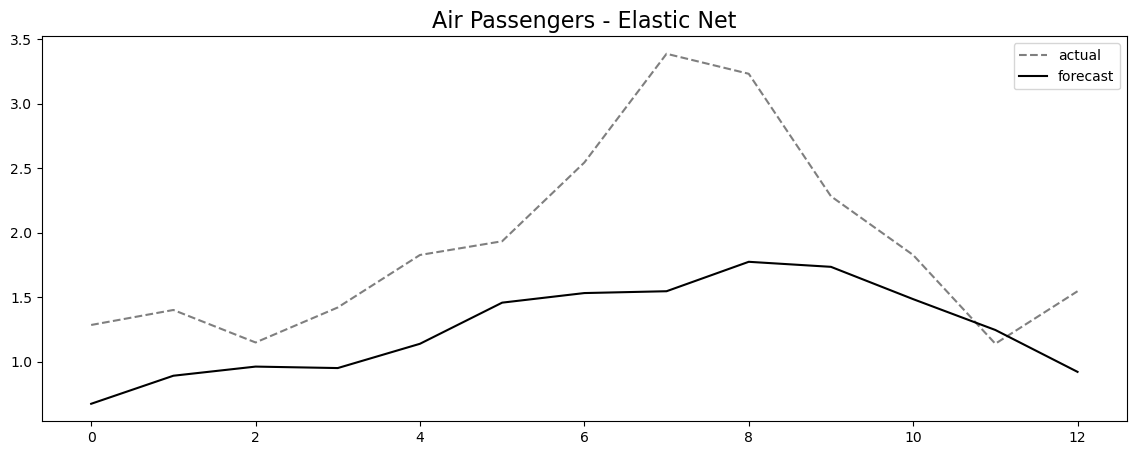

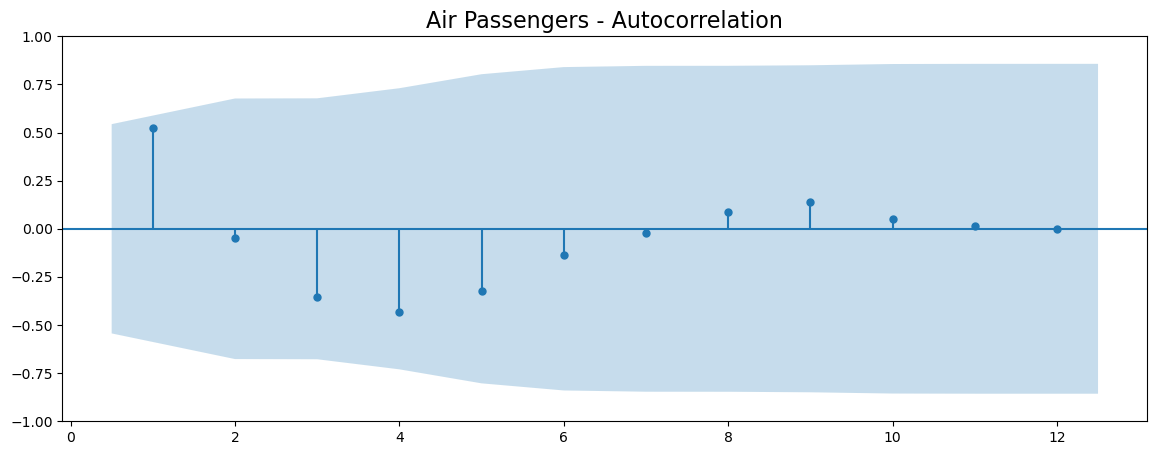

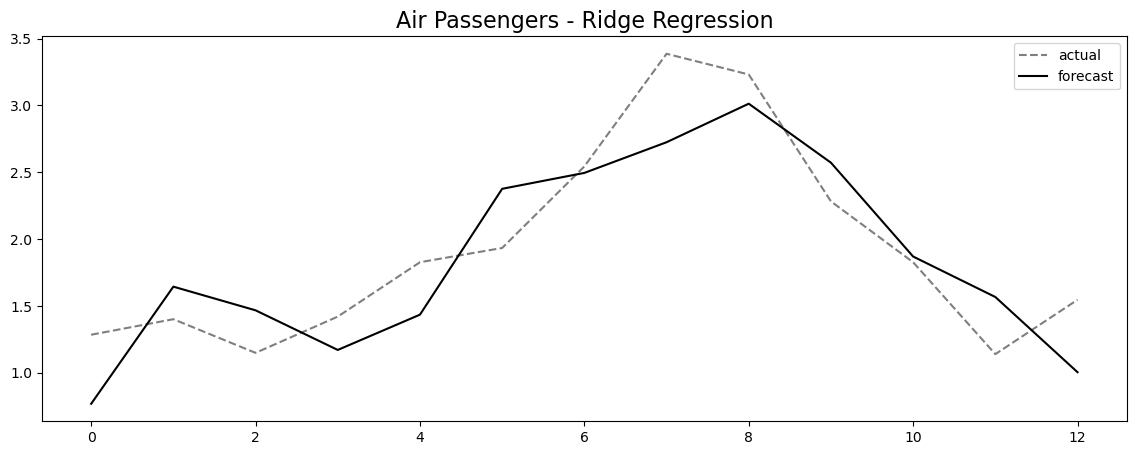

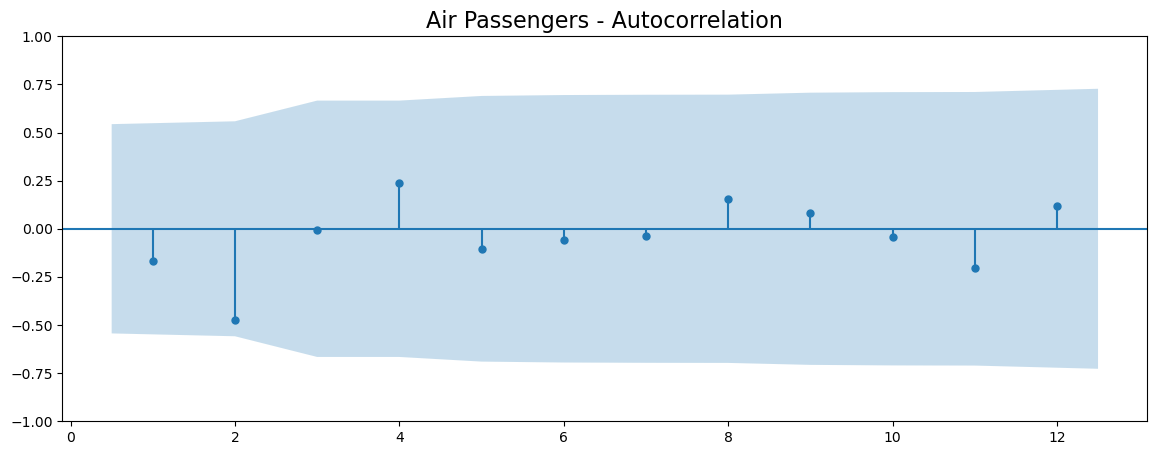

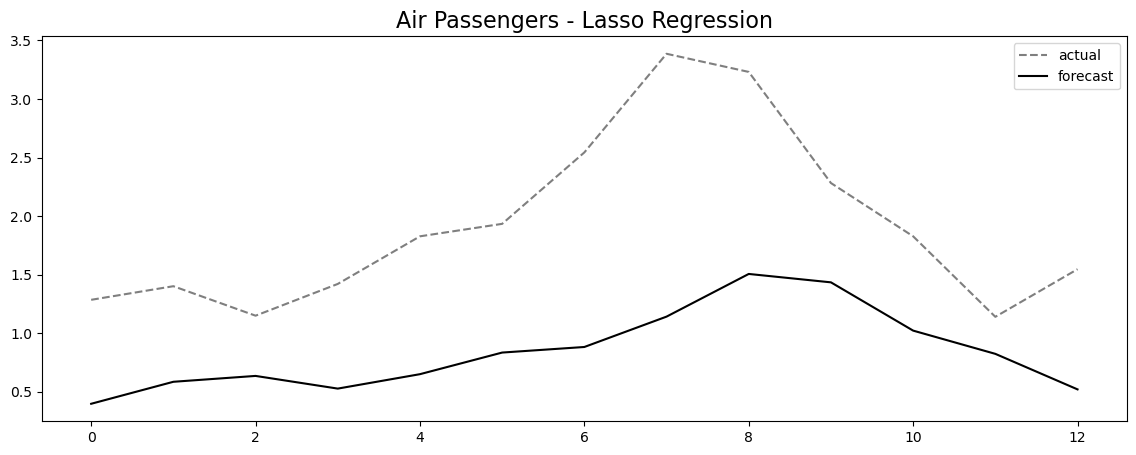

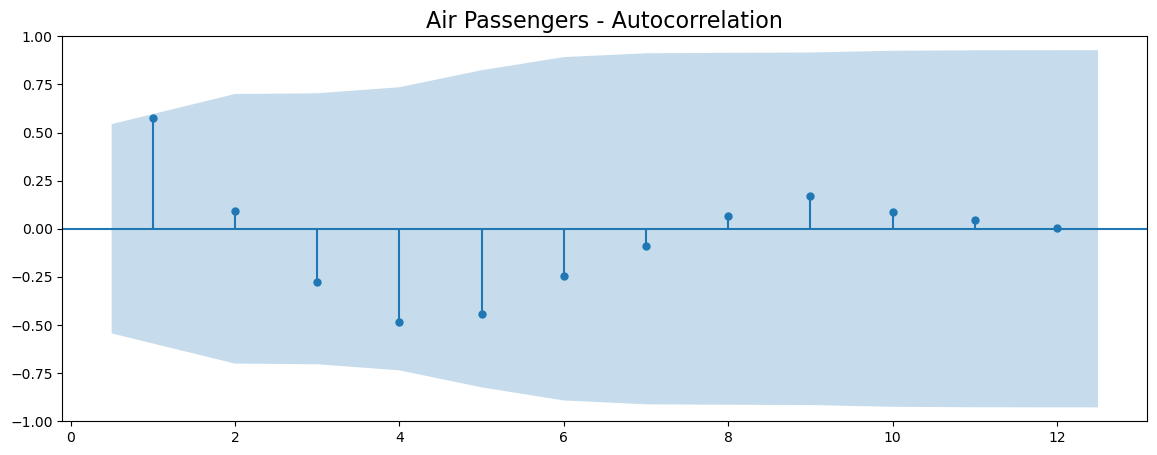

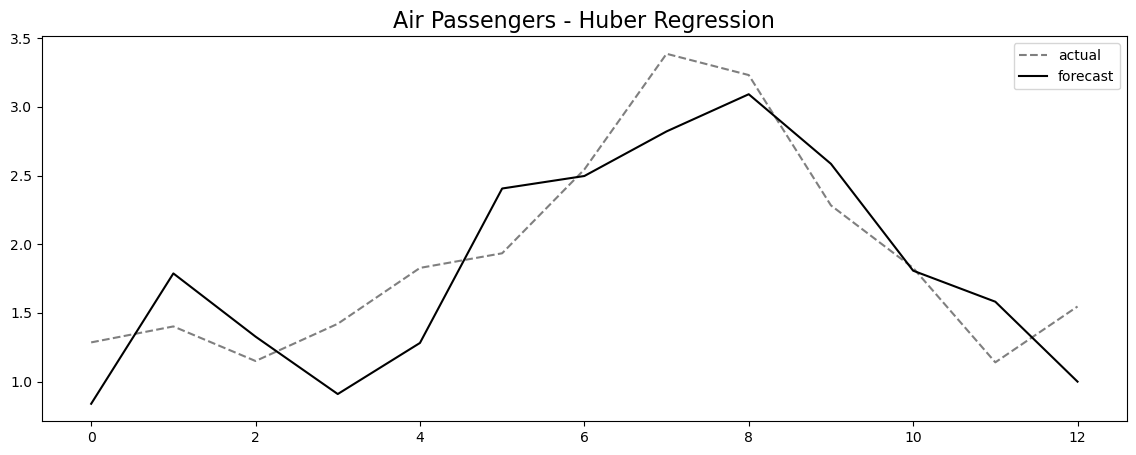

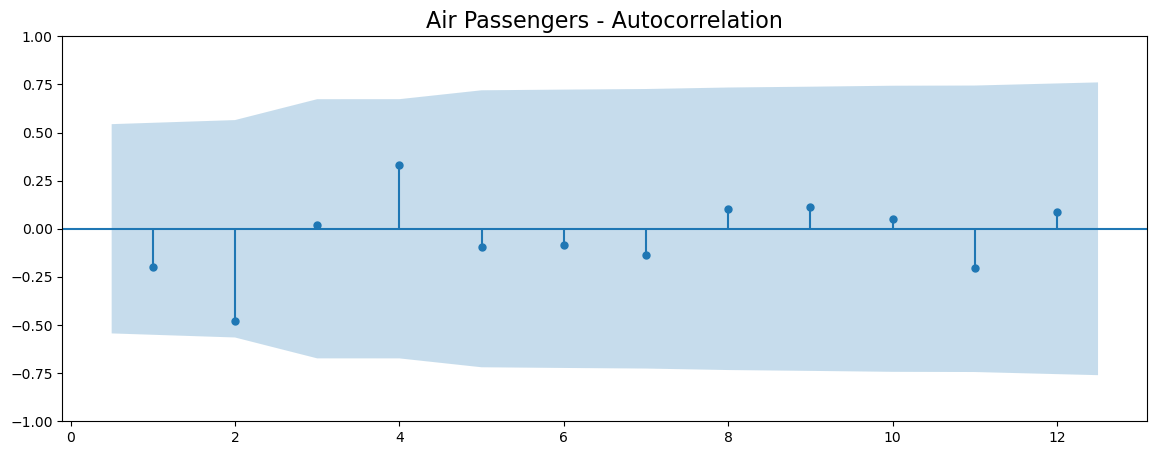

In [47]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, air_results, 'Air Passengers')


#### Energy Consumption Plots

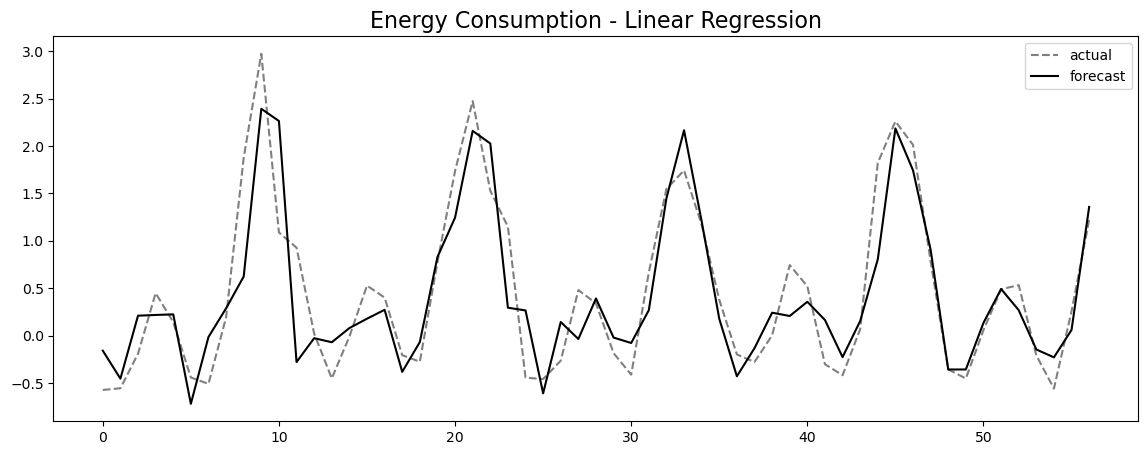

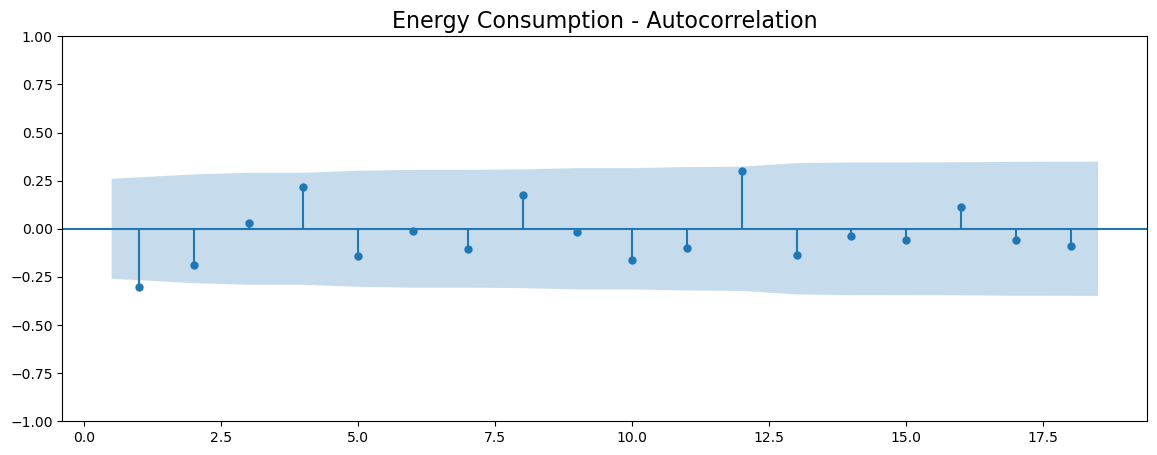

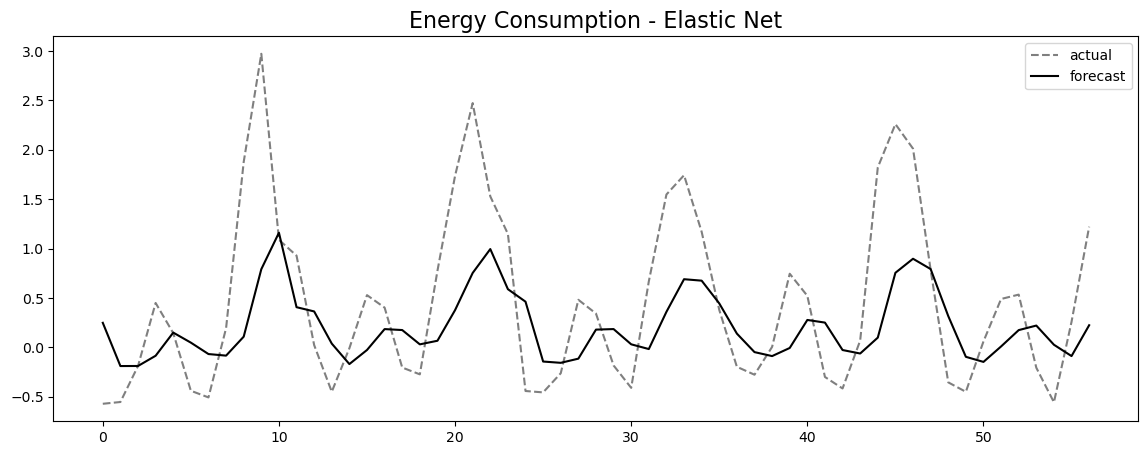

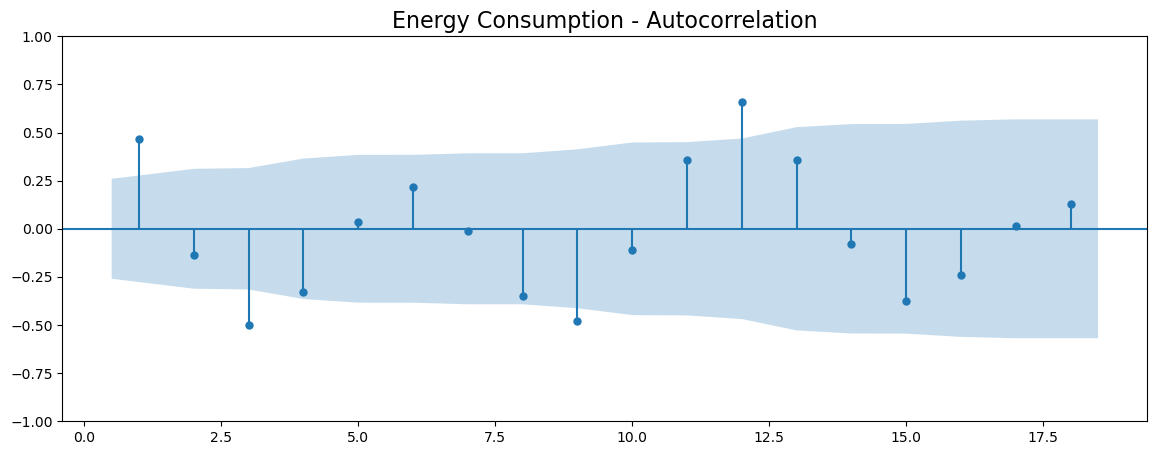

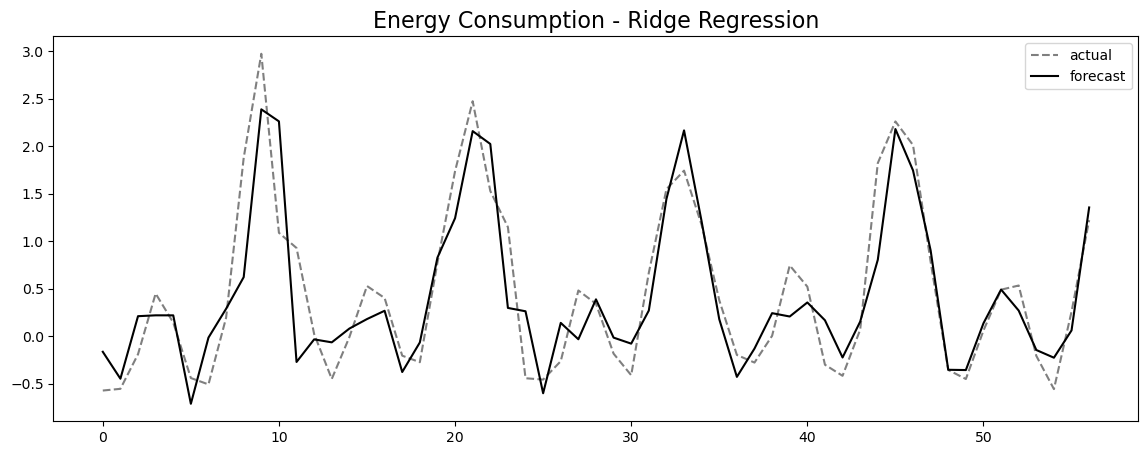

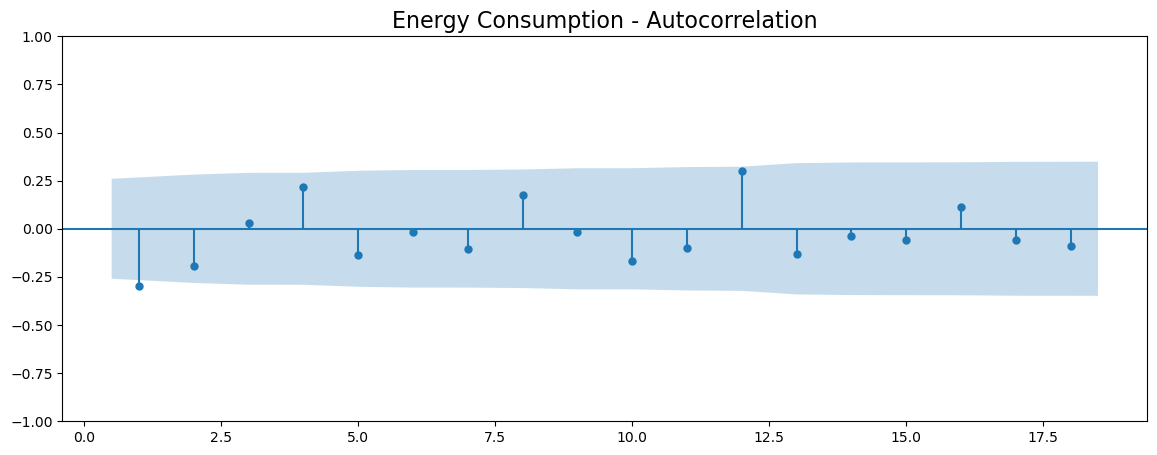

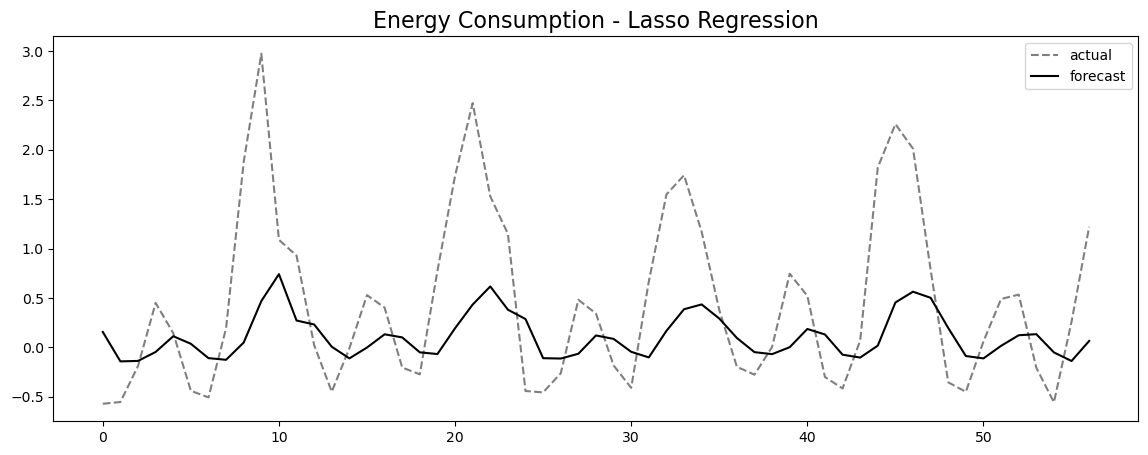

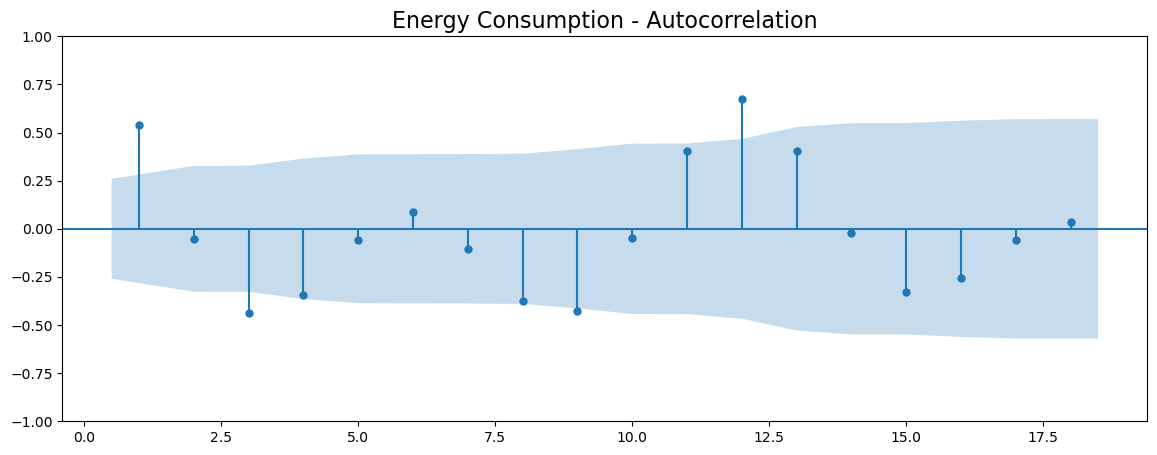

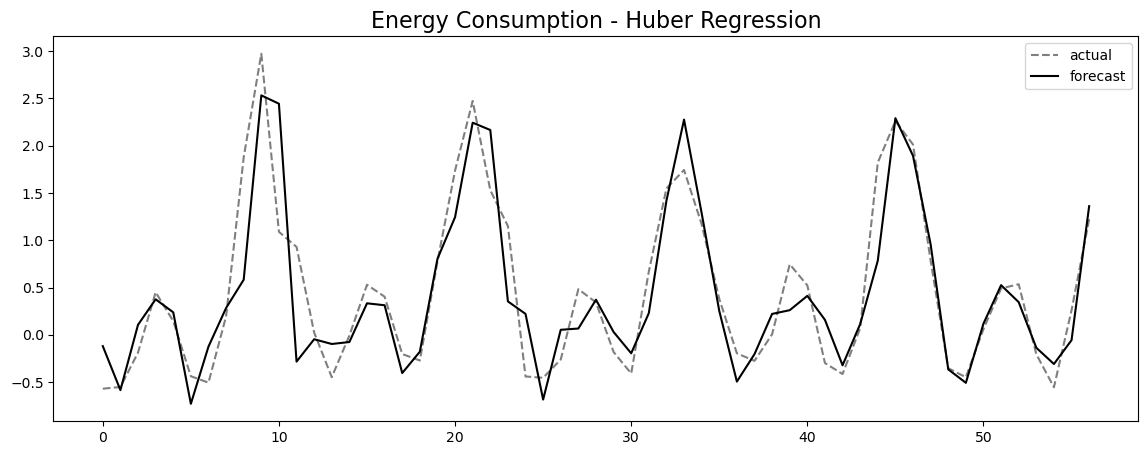

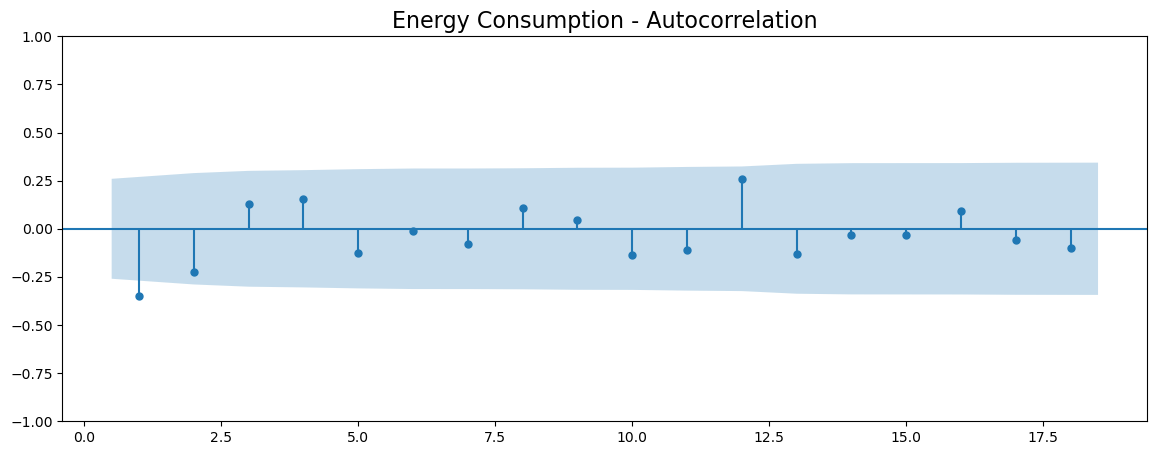

In [48]:
plot_results(cols, en_results, 'Energy Consumption')

#### Daily Temperature Plots

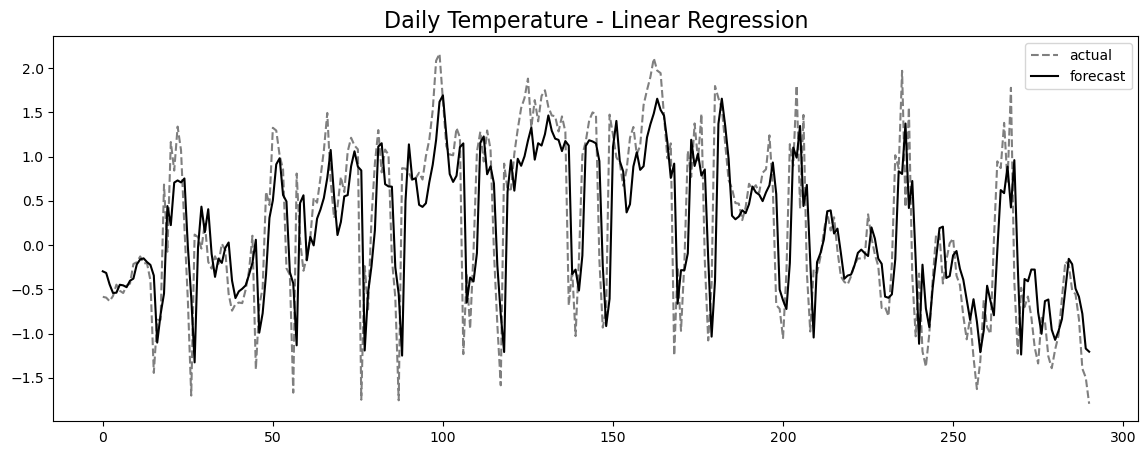

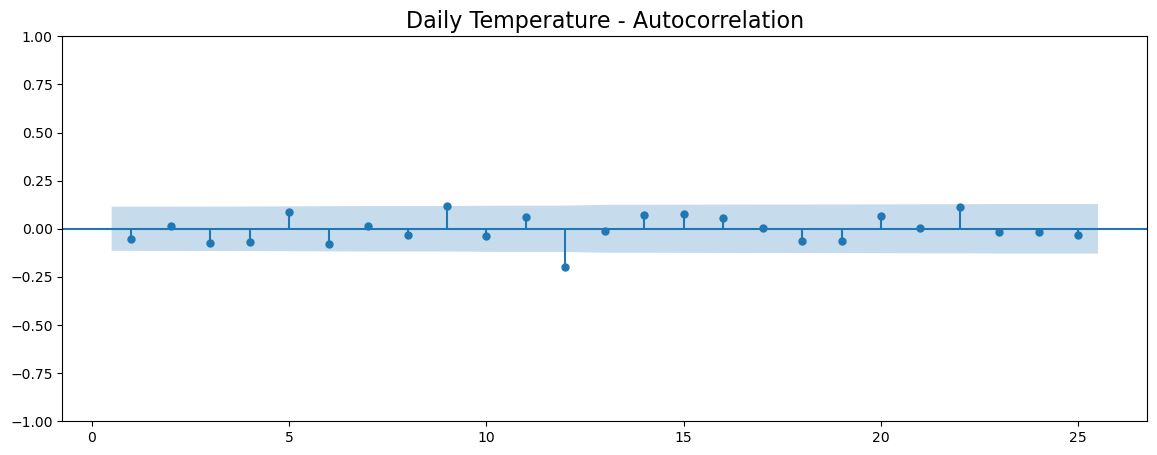

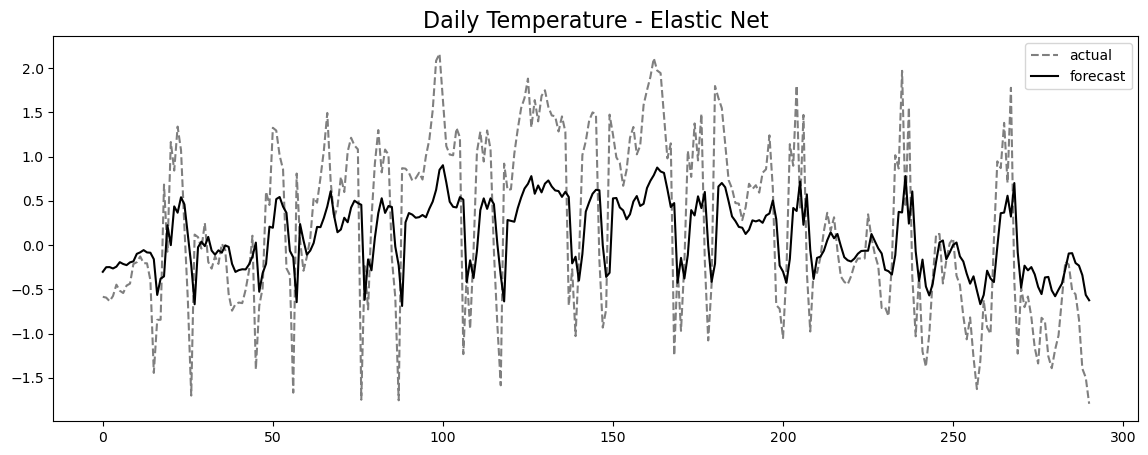

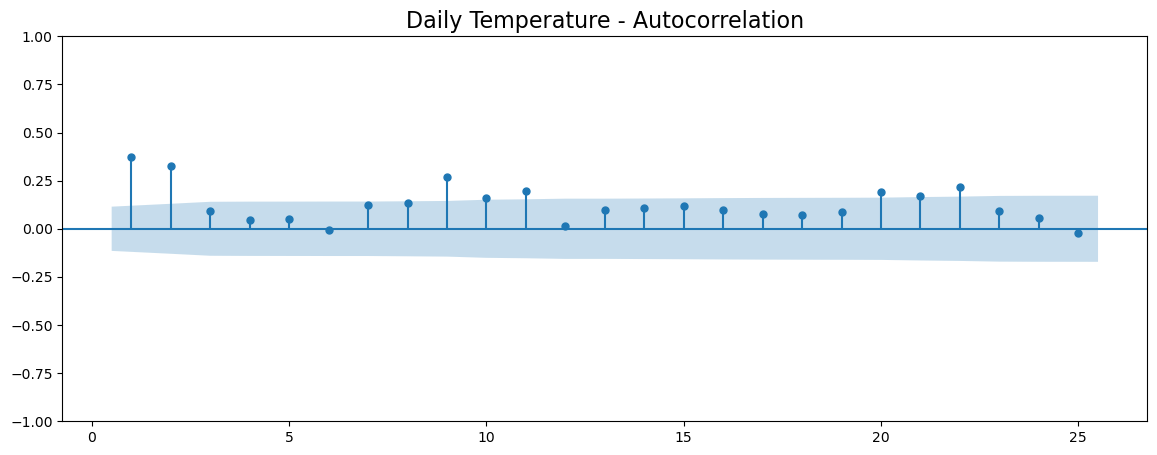

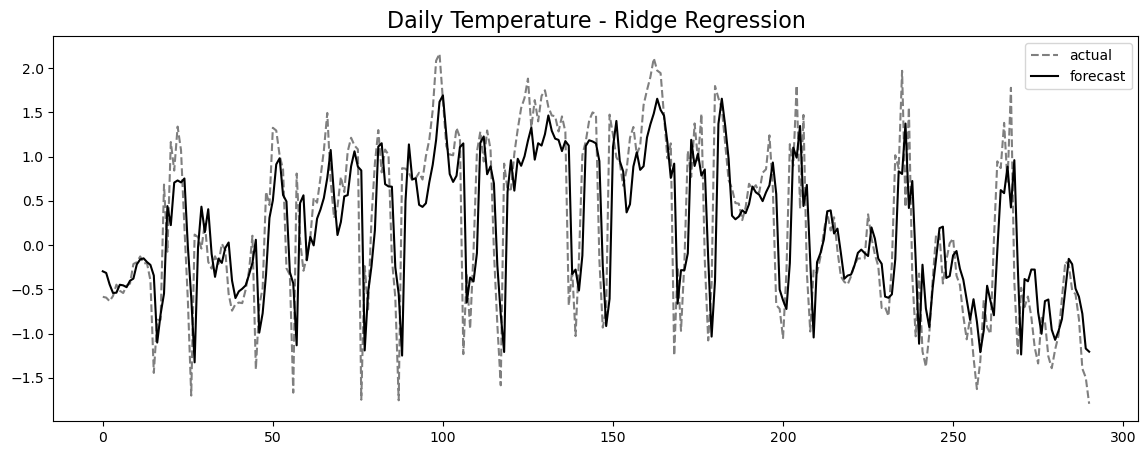

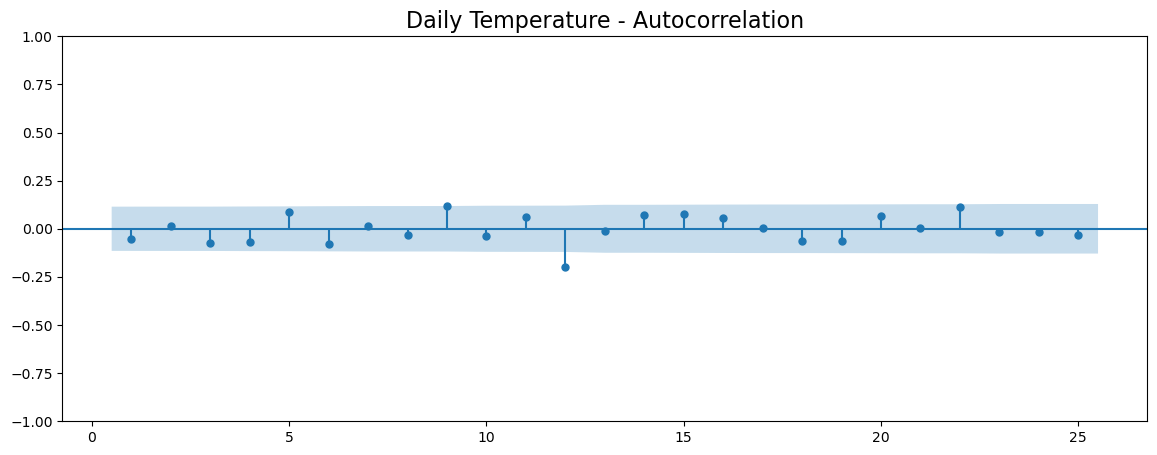

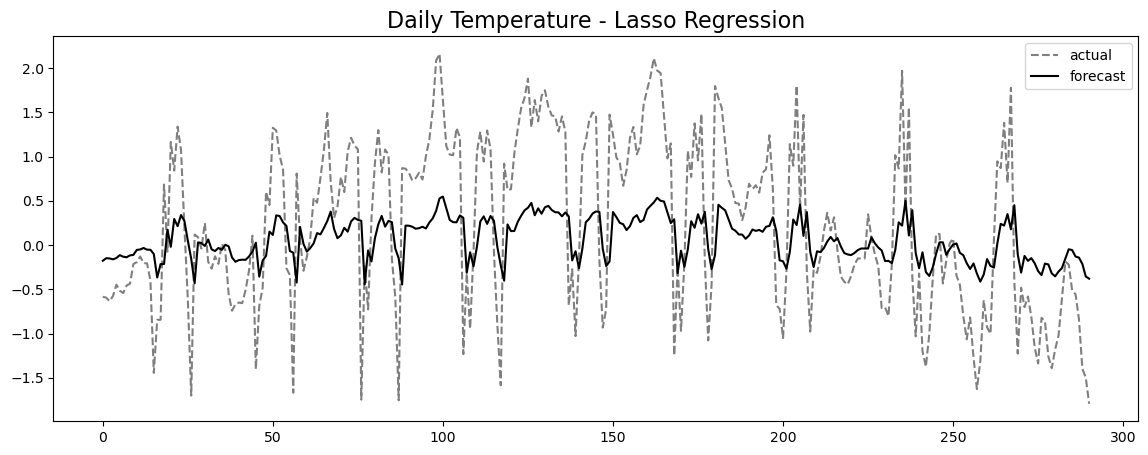

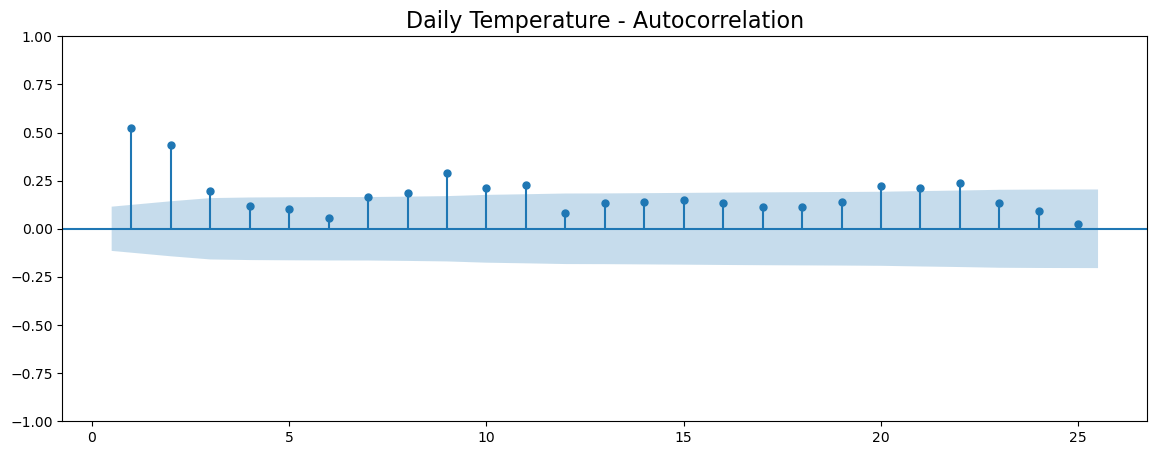

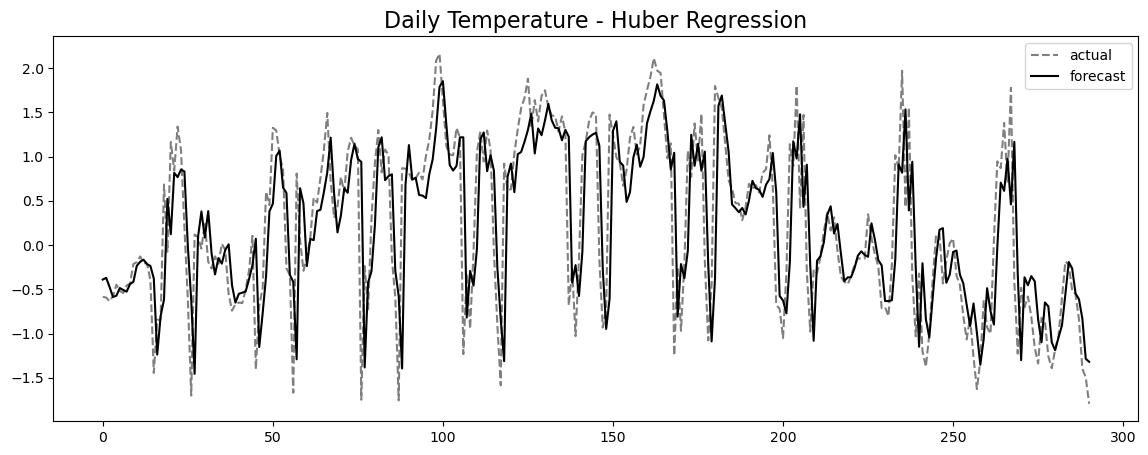

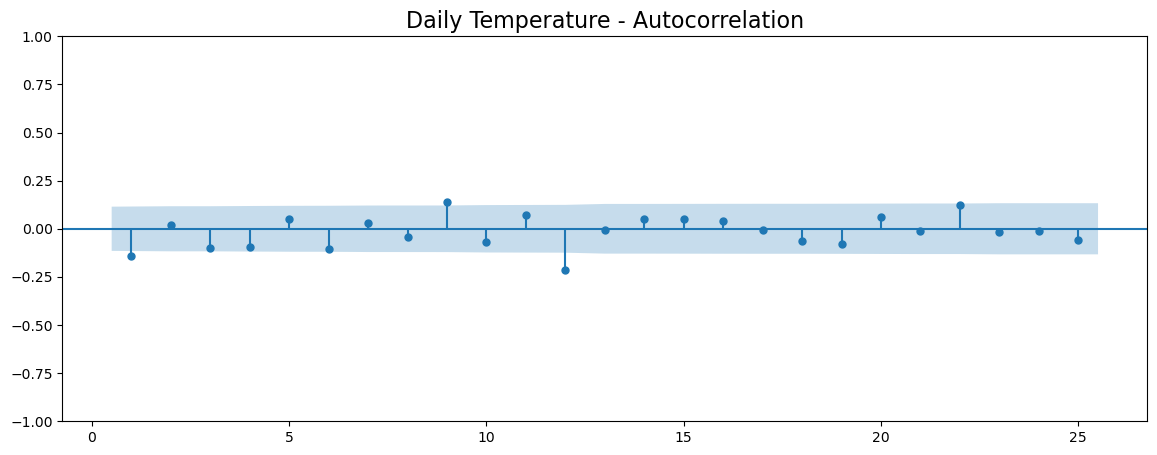

In [49]:
plot_results(cols, dw_results, 'Daily Temperature')

## How it works

In [50]:
cols = ['Model Name', 'Model']
en_models = en_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[ 0.02739136  0.02052173  0.03768302  0.06630472  0.01417452 -0.08727704
  0.02856578 -0.13640839  0.14165493  0.70683461]
Elastic Net
[0.         0.         0.         0.         0.         0.
 0.         0.         0.04077799 0.37835549]
Ridge Regression
[ 0.0273999   0.02054709  0.0377177   0.06625515  0.01414968 -0.08721396
  0.02844889 -0.13622568  0.14175768  0.7065417 ]
Lasso Regression
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.2536153]


### Energy Consumption

**Regression Coefficients and Feature Selection**

In [51]:
en_10 = en_reg[['y', 'x_10']]

train_en10, test_en10 = split_data(en_10, test_split=0.10)
scaler_en10 = Standardize()
train_en10_s, test_en10_s = scaler_en.fit_transform(train_en10, test_en10)

en_10_results = train_different_models(train_en10_s, test_en10_s, regressors)

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_10_results = pd.DataFrame(en_results)
en_10_results[cols].sort_values('MASE')

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.431651  1.419527  0.525526
2   Ridge Regression  0.433192  1.586383  0.560450
0  Linear Regression  0.433747  1.583406  0.560989
1        Elastic Net  0.747657  1.822362  1.013425
3   Lasso Regression  0.834356  1.548537  1.108092

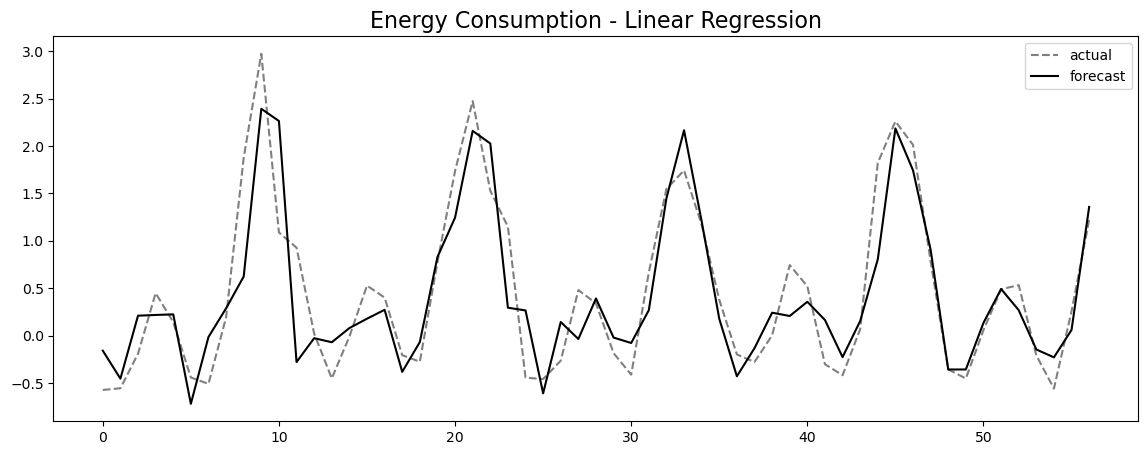

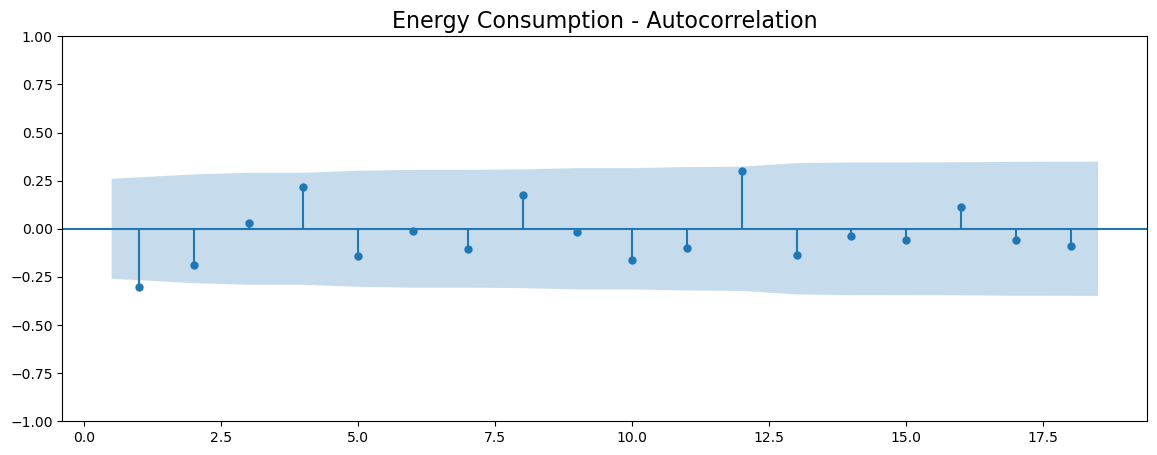

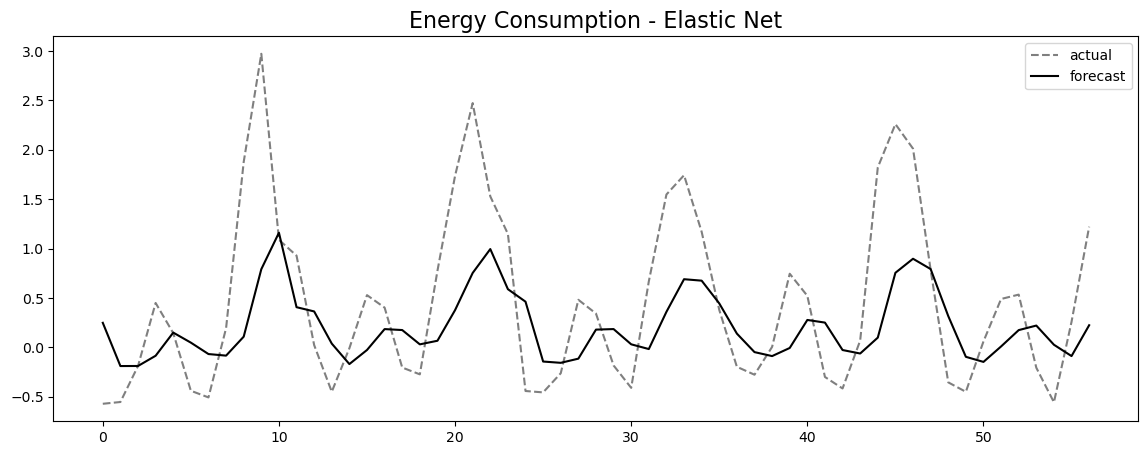

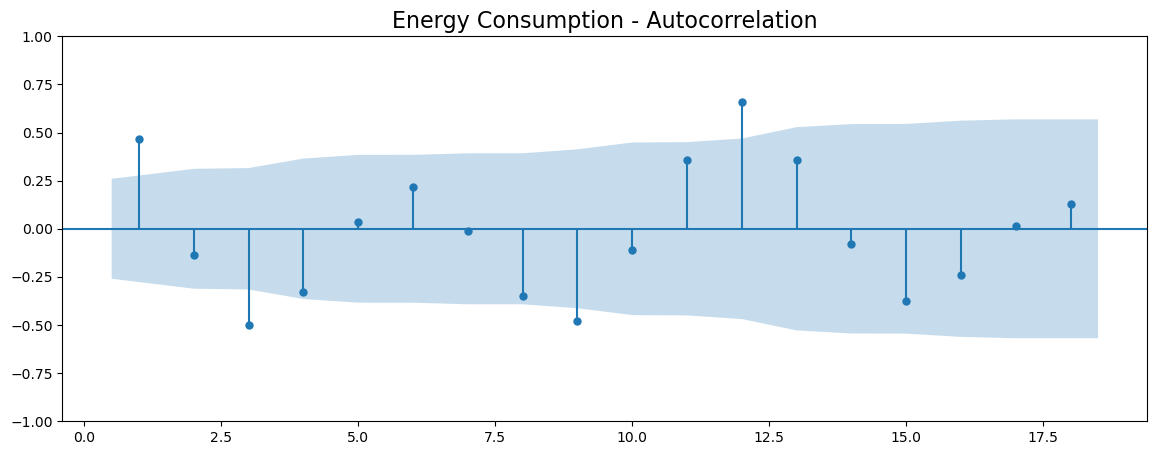

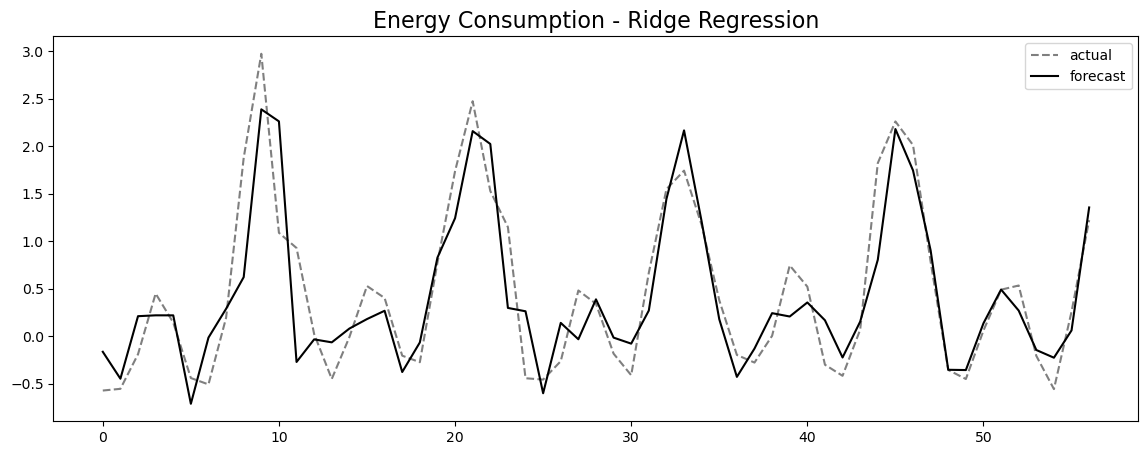

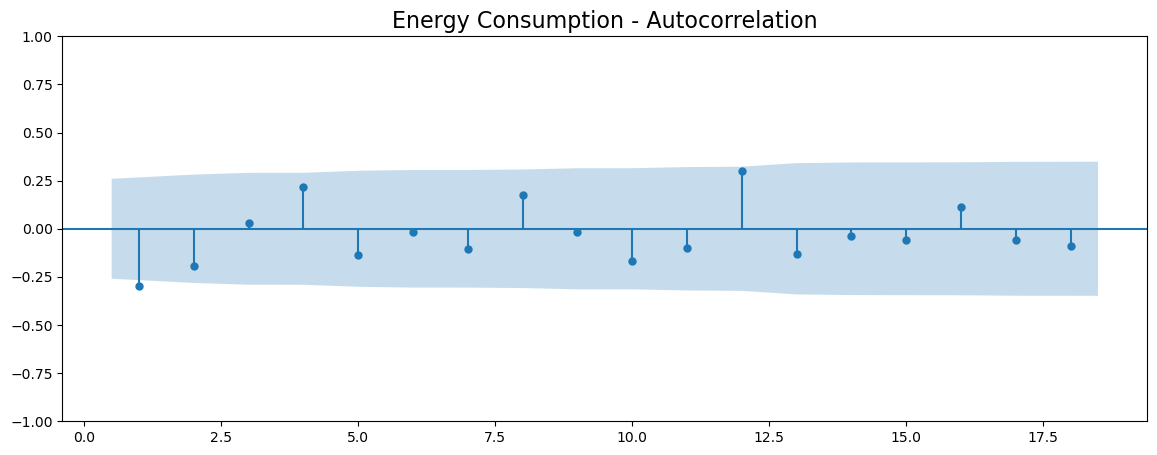

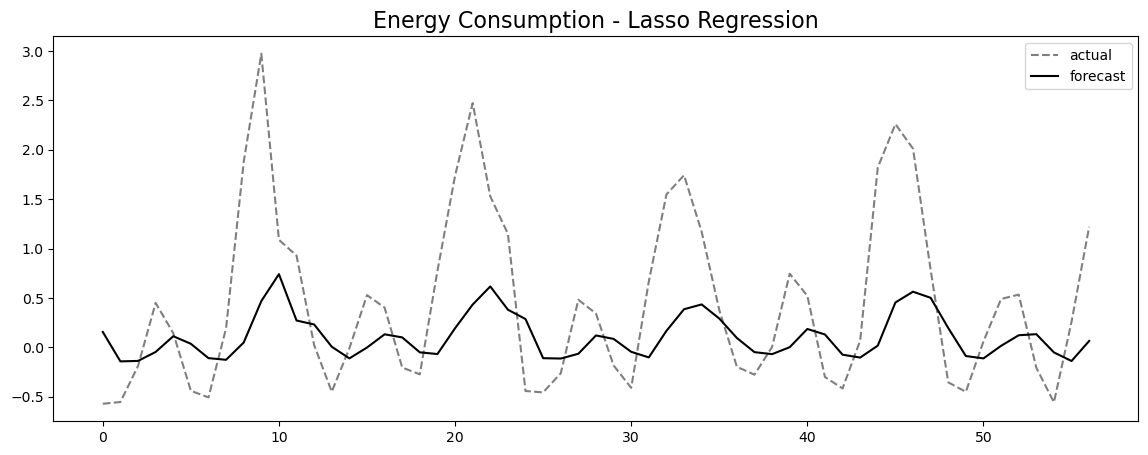

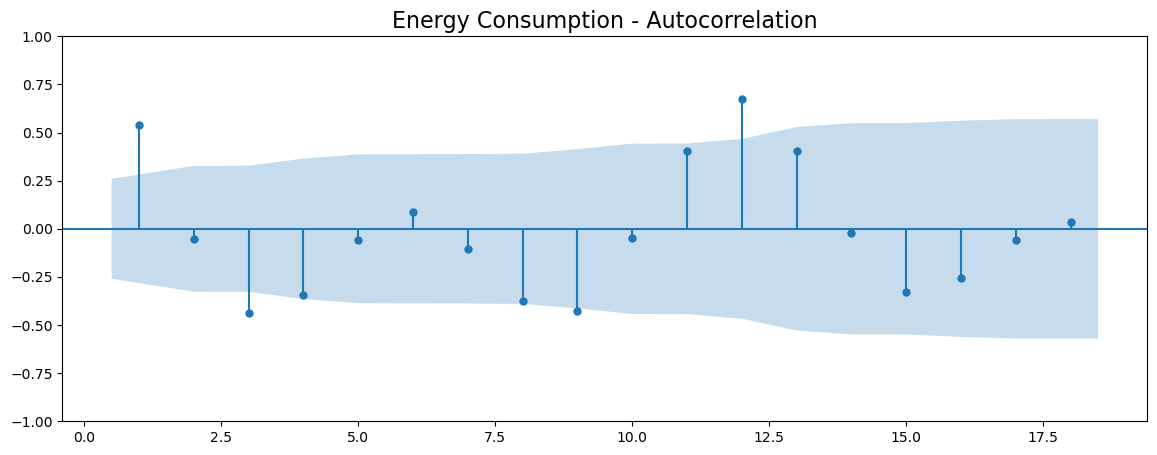

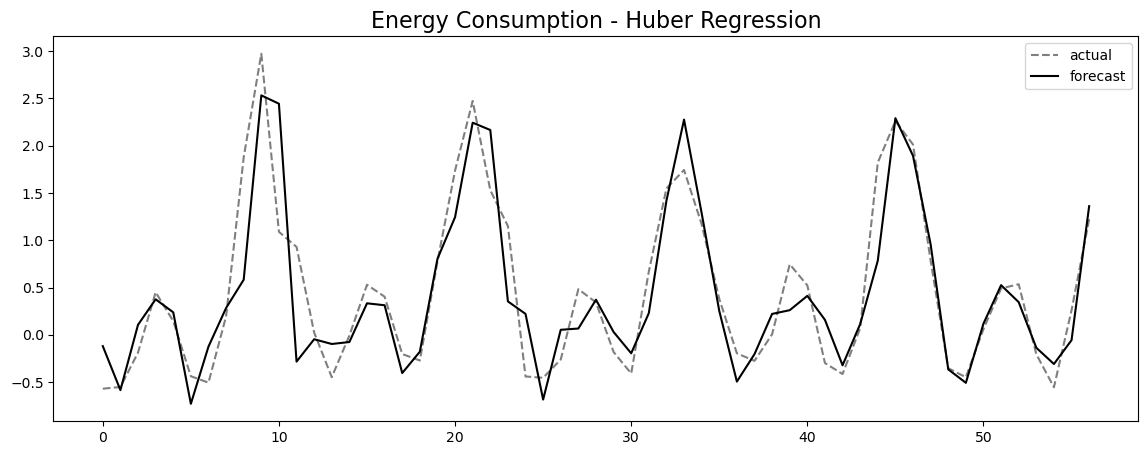

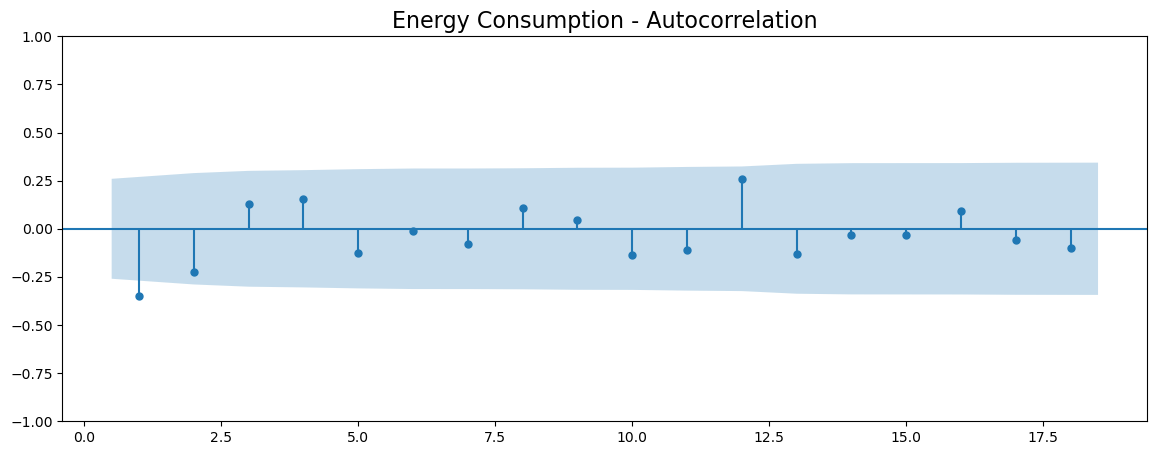

In [52]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, en_10_results, 'Energy Consumption')

In [53]:
cols = ['Model Name', 'Model']
en_models = en_10_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[0.75051783]
Elastic Net
[0.39987585]
Ridge Regression
[0.74979687]
Lasso Regression
[0.24955629]


# Recipe 3. Multi-Step Forecasting using Linear Regression Models with Scikit-Learn

In [54]:
air_results = train_different_models(train_air_s, test_air_s, regressors)
en_results = train_different_models(train_en_s, test_en_s, regressors)
dw_results = train_different_models(train_dw_s, test_dw_s, regressors)

air_results = pd.DataFrame(air_results)
en_results = pd.DataFrame(en_results)
dw_results = pd.DataFrame(dw_results)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [55]:
dw_results

Model Name                                       Model      RMSE  \
0  Linear Regression       LinearRegression(fit_intercept=False)  0.646648   
1        Elastic Net  ElasticNet(alpha=0.5, fit_intercept=False)  0.737896   
2   Ridge Regression       Ridge(alpha=0.5, fit_intercept=False)  0.646639   
3   Lasso Regression       Lasso(alpha=0.5, fit_intercept=False)  0.814609   
4   Huber Regression         HuberRegressor(fit_intercept=False)  0.655729   

       MAPE      MASE                                               yhat  \
0  1.037424  0.990057  [-0.2961925386523873, -0.31451394354806544, -0...   
1  0.913599  1.300792  [-0.3018190700137872, -0.24968002141505882, -0...   
2  1.037273  0.990085  [-0.29613870275885346, -0.3144177205378609, -0...   
3  0.911730  1.468567  [-0.17687814111972053, -0.14827924485769858, -...   
4  1.083826  0.968735  [-0.3890440939401397, -0.36999768608750505, -0...   

                                               resid  \
0  [-0.2880322182881527, -0.27872252321501606, -0...   
1  [-0.2824056869267528, -0.34355644534802265, -0...   
2  [-0.28808605418168654, -0.2788187462252206, -0...   
3  [-0.40734661582081944, -0.4449572219053829, -0...   
4  [-0.19518066300040027, -0.22323878067557645, -...   

                                              actual  
0  [-0.58422475694054, -0.5932364667630815, -0.63...  
1  [-0.58422475694054, -0.5932364667630815, -0.63...  
2  [-0.58422475694054, -0.5932364667630815, -0.63...  
3  [-0.58422475694054, -0.5932364667630815, -0.63...  
4  [-0.58422475694054, -0.5932364667630815, -0.63...

In [56]:
test_dw_s.iloc[[-1]]

x_1       x_2       x_3       x_4       x_5       x_6  \
DateTime                                                                 
2016-12-22 -1.180203 -1.022581 -0.604237 -0.189764 -0.224464 -0.514589   

                 x_7       x_8       x_9      x_10         y  
DateTime                                                      
2016-12-22 -0.559203 -0.839812 -1.397096 -1.496642 -1.792546

In [57]:
models = dw_results[['Model Name','Model']]
models

Model Name                                       Model
0  Linear Regression       LinearRegression(fit_intercept=False)
1        Elastic Net  ElasticNet(alpha=0.5, fit_intercept=False)
2   Ridge Regression       Ridge(alpha=0.5, fit_intercept=False)
3   Lasso Regression       Lasso(alpha=0.5, fit_intercept=False)
4   Huber Regression         HuberRegressor(fit_intercept=False)

In [58]:
# another version using NumPy
# def multi_step_forecast(data, model, steps=10):
#     forecast = []
#     for i in range(steps):
#         one_step_pred = model.predict(data.reshape(1,-1))[0]
#         forecast.append(one_step_pred)
#         data = np.roll(data, shift=-1)
#         data[-1] = one_step_pred
#     return np.array(forecast)

In [59]:
def multi_step_forecast(data, model, steps=10):
    forecast = []
    for i in range(steps):
        one_step_pred = model.predict(np.array(data).reshape(1,-1))[0]
        forecast.append(one_step_pred)
        _ = data.pop(0)
        data.append(one_step_pred)
    return np.array(forecast)

### Daily Temperature

In [60]:
frcst_dw = {}
models = dw_results[['Model Name','Model']]
dw_ms = test_dw_s.drop(columns=['y']).iloc[-1].tolist()

for i in models.iterrows():
    pred = multi_step_forecast(dw_ms, steps=10, model=i[1]['Model'])
    pred = scaler_dw.inverse_y(pred)
    frcst_dw[i[1]['Model Name']] = pred    

### Air Passengers

In [61]:
models = air_results[['Model Name','Model']]
air_ms = test_air.drop(columns=['y']).iloc[-1].tolist()
frcst_air = {}
for i in models.iterrows():
    pred = multi_step_forecast(air_ms, steps=10, model=i[1]['Model'])
    pred = scaler_air.inverse_y(pred)
    frcst_air[i[1]['Model Name']] = pred   

### Energy Consumption

In [62]:
models = en_results[['Model Name','Model']]
en_ms = test_en_s.drop(columns=['y']).iloc[-1].tolist()
frcst_en = {}
for i in models.iterrows():
    pred = multi_step_forecast(en_ms, steps=10, model=i[1]['Model'])
    pred = scaler_en.inverse_y(pred)
    frcst_en[i[1]['Model Name']] = pred   

#### Example on Daily Temperature Data

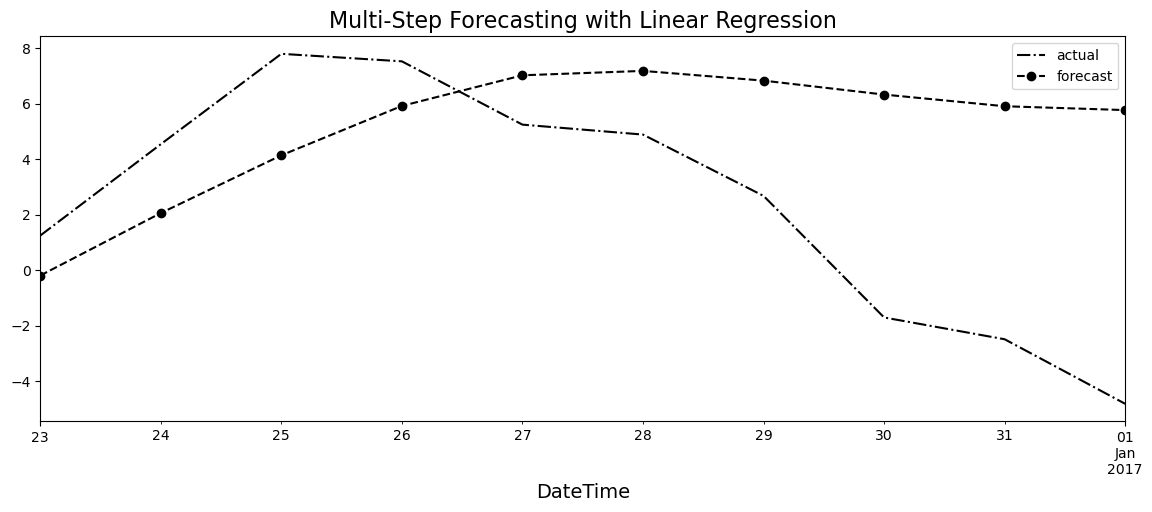

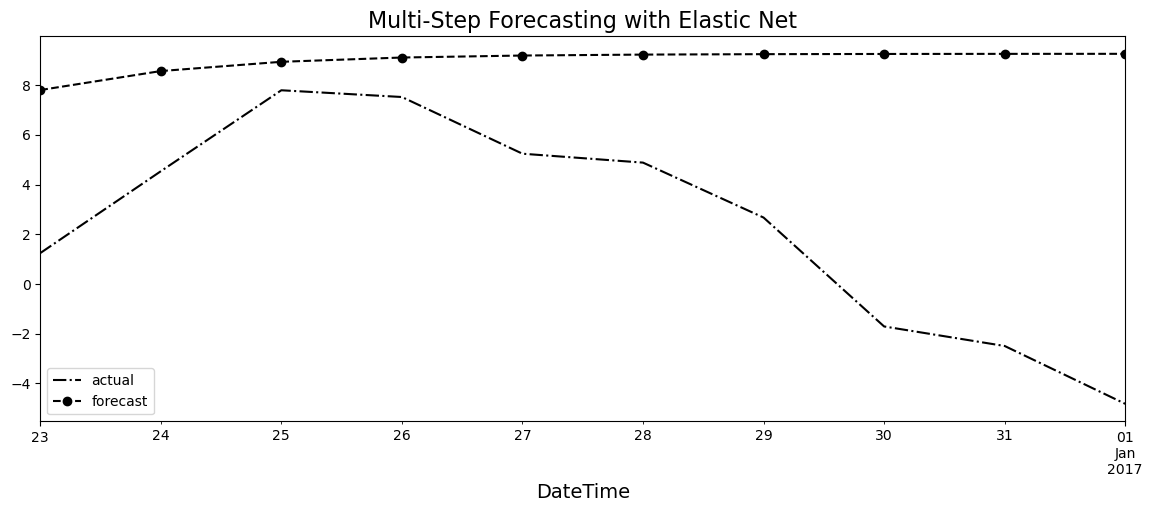

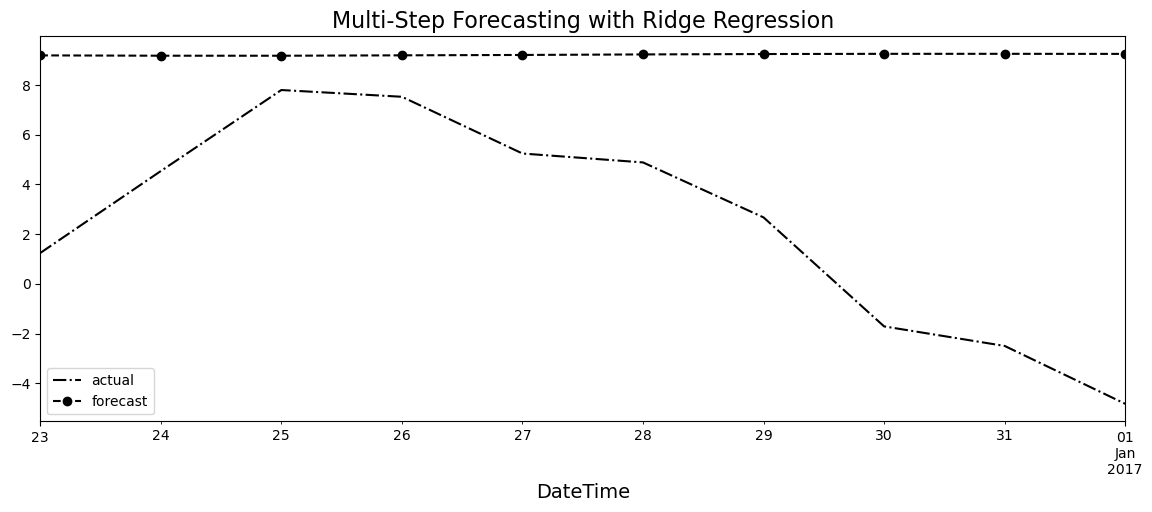

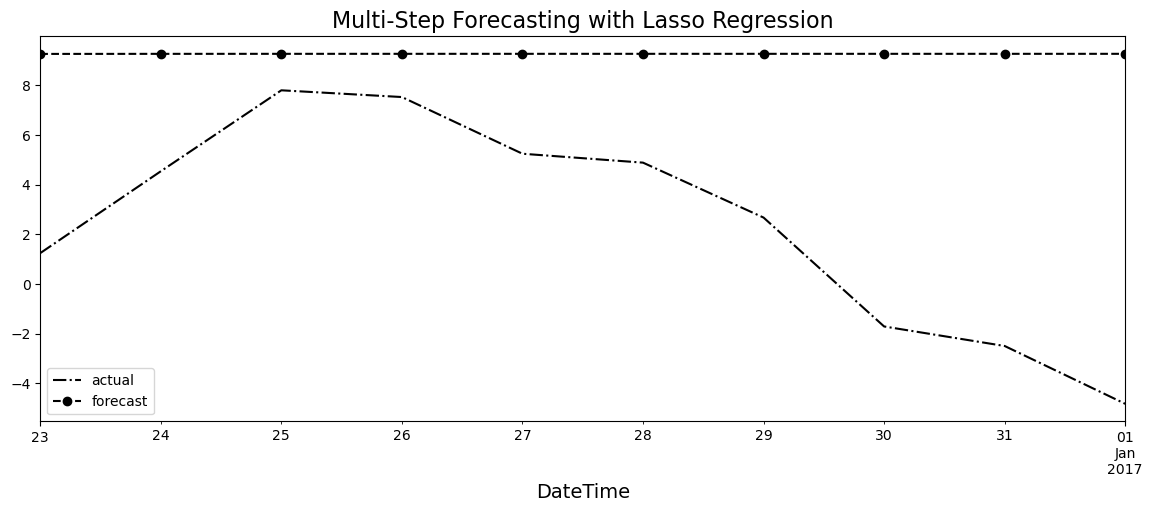

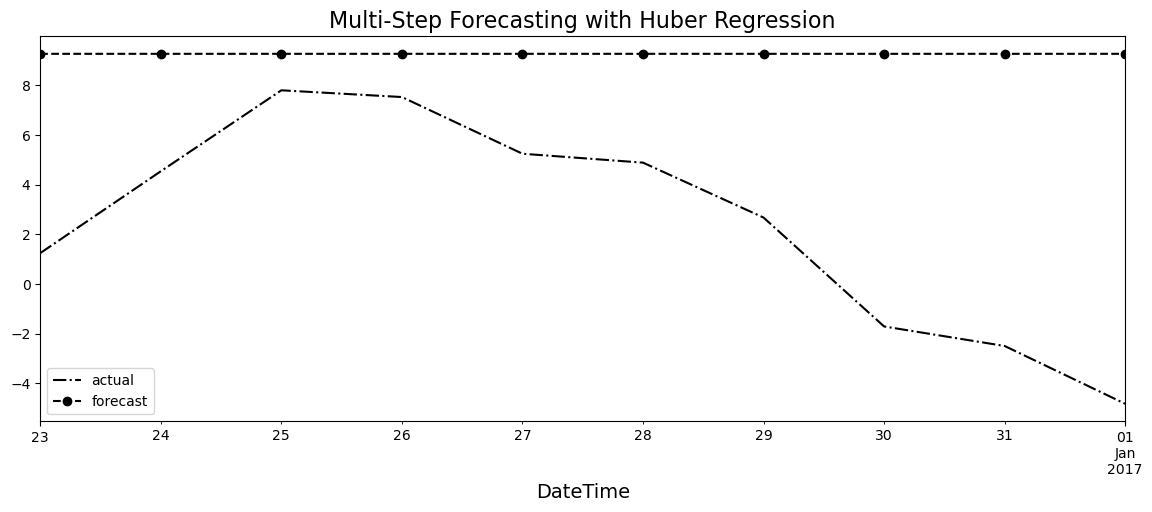

In [63]:
for name, pred in frcst_dw.items():
    actual = dw_cp.iloc[-10:]
    ax = actual.plot(style='k-.')
    pd.Series(pred, index=dw_cp.index[-10:]).plot(style='k--o', ax=ax)
    plt.title(f'Multi-Step Forecasting with {name}')
    plt.legend(['actual', 'forecast'])
    plt.show()

## There is more

In [64]:
def multiple_output(df, window_in, window_out):
    d = df.values
    x = []
    y = []
    n = len(df)
    idx = df.index[:-window_in]
    print(len(idx))
    for start in range(n-window_in):
        end = start + window_in
        out = end + window_out
        x.append(d[start:end].ravel())
        y.append(d[end:out].ravel())
        
    cols_x = [f'x_{i}' for i in range(1, window_in+1)]
    cols_y = [f'y_{i}' for i in range(1, window_out+1)]

    df_xs = pd.DataFrame(x,  index=idx, columns=cols_x)
    df_y = pd.DataFrame(y,index=idx, columns=cols_y)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [65]:
win_in, win_out = 10, 10
dw_mo = multiple_output(dw_cp, win_in, win_out)

train_dw, test_dw = split_data(dw_mo, test_split=0.10)
scaler_dw = Standardize()
train_dw_s, test_dw_s = scaler_dw.fit_transform(train_dw,test_dw)

2913


In [66]:
dw_mo.columns

Index(['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10',
       'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'y_10'],
      dtype='object')

In [67]:
train_dw_s.shape

(2614, 20)

In [68]:
lr = LinearRegression()

In [69]:
X_train, y_train = train_dw_s.iloc[: , :win_in], train_dw_s.iloc[:, win_out:]
X_test, y_test = test_dw_s.iloc[: , :win_in], test_dw_s.iloc[:, win_out:]

In [70]:
lr.fit(X_train, y_train)

LinearRegression()

In [71]:
mo_pred = scaler_dw.inverse_y(lr.predict(X_test)[-1])
dates = pd.date_range('2016-12-13', freq='D', periods=20)
inputs, outputs = dates[:win_in], dates[win_out:]

In [72]:
test_dw.iloc[-1].values.shape

(20,)

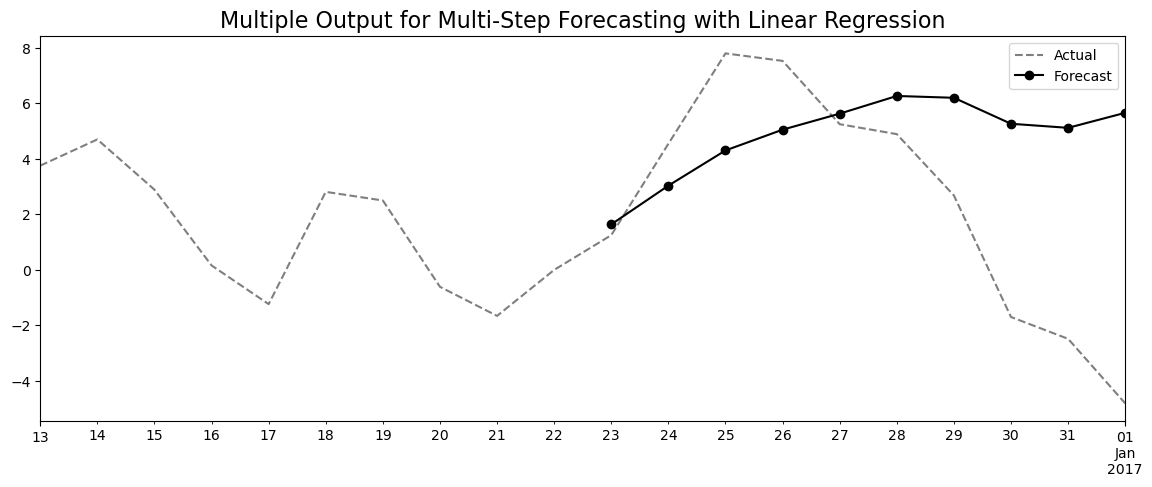

In [73]:
pd.Series(test_dw.iloc[-1].values, index=dates).plot(style='k--', alpha=0.5)
pd.Series(mo_pred, index=outputs).plot(style='k-o')
plt.title('Multiple Output for Multi-Step Forecasting with Linear Regression')
plt.legend(['Actual', 'Forecast'])
#plt.savefig('../../../Packt-Time-Series-Cookbook/Chapters/Ch12/images/fig_12.10.png', bbox_inches='tight', dpi=600)

# Recipe 4. Forecasting using Non-Linear Models with sktime

Loading required modules

In [74]:
from sklearn.ensemble import (RandomForestRegressor, 
                              GradientBoostingRegressor, 
                              ExtraTreesRegressor)


from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.all import (
        Deseasonalizer, Detrender, 
        temporal_train_test_split,
        mean_absolute_percentage_error as mape, 
        mean_squared_percentage_error as mspe,
        mean_squared_error as mse, 
        ForecastingHorizon, 
        NaiveForecaster,
        TransformedTargetForecaster,
        PolynomialTrendForecaster
)
from sktime.forecasting.compose import make_reduction


In [75]:
import sktime
sktime.__version__

'0.22.0'

Loading the dataset and inspecting the data

In [76]:
df = energy.copy()

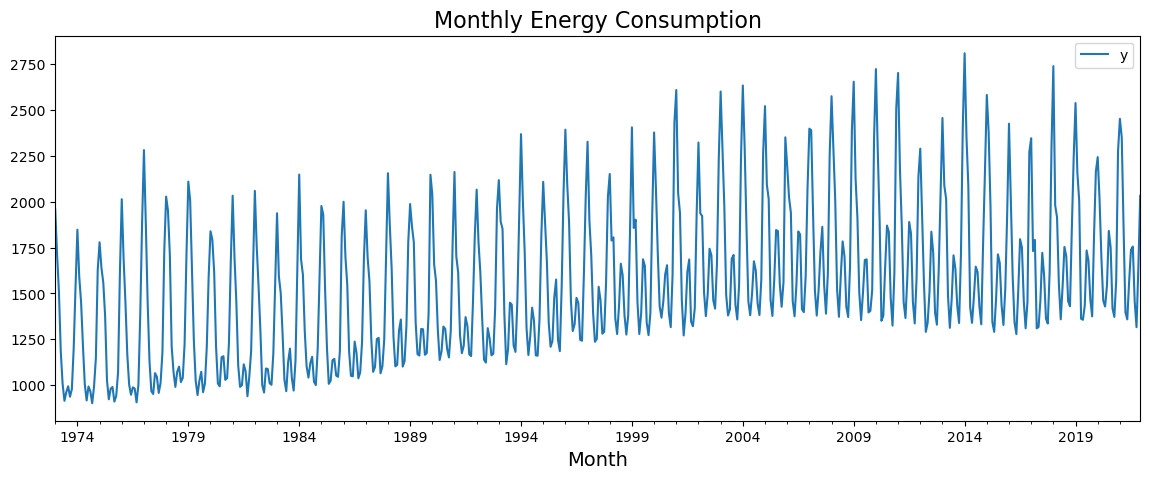

In [77]:
df.plot(title='Monthly Energy Consumption');plt.show()

In [78]:
df.head()

y
Month               
1973-01-01  1957.641
1973-02-01  1712.143
1973-03-01  1510.079
1973-04-01  1183.421
1973-05-01  1006.326

In [79]:
df.tail()

y
Month               
2021-08-01  1755.212
2021-09-01  1456.901
2021-10-01  1315.799
2021-11-01  1644.306
2021-12-01  2032.352

In [80]:
df.index.year.unique()

Int64Index([1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
            1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
            1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
            2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
            2017, 2018, 2019, 2020, 2021],
           dtype='int64', name='Month')

In [81]:
df.shape

(588, 1)

**Different ways to split your time series**


In [82]:
train, test = split_data(df)

In [83]:
train.shape

(500, 1)

In [84]:
test.shape

(88, 1)

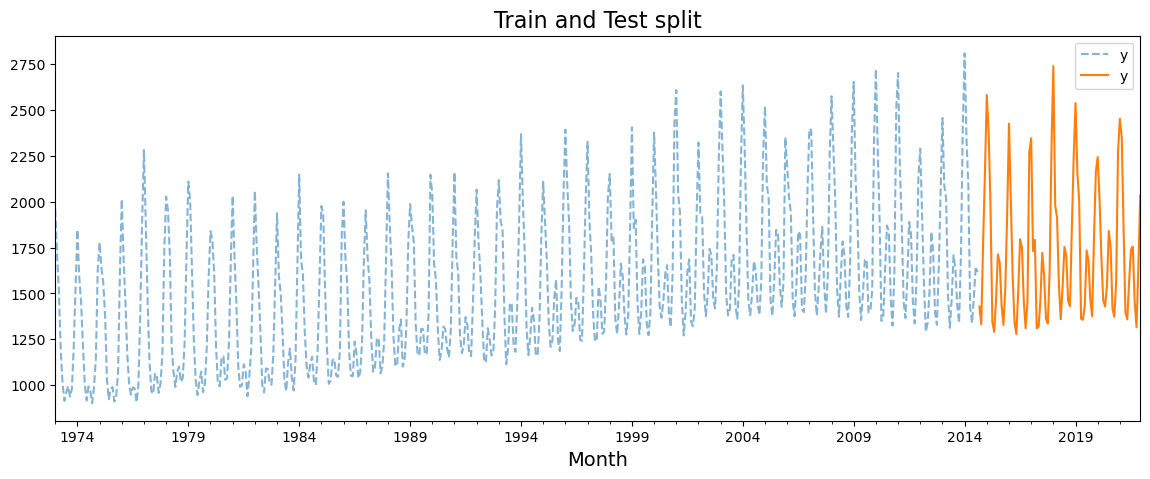

In [85]:
ax = train.plot(style='--', alpha=0.55)
test.plot(ax=ax)
plt.title('Train and Test split')
plt.show()

In [86]:
test.shape

(88, 1)

In [87]:
test.tail()

y
Month               
2021-08-01  1755.212
2021-09-01  1456.901
2021-10-01  1315.799
2021-11-01  1644.306
2021-12-01  2032.352

In [88]:
from statsmodels.tsa.api import seasonal_decompose, adfuller

In [89]:
adfuller(df)

(-1.4497331132437508,
 0.5582151234544172,
 12,
 575,
 {'1%': -3.4417738839904657,
  '5%': -2.8665796253604015,
  '10%': -2.569453974291115},
 6916.6482184861825)

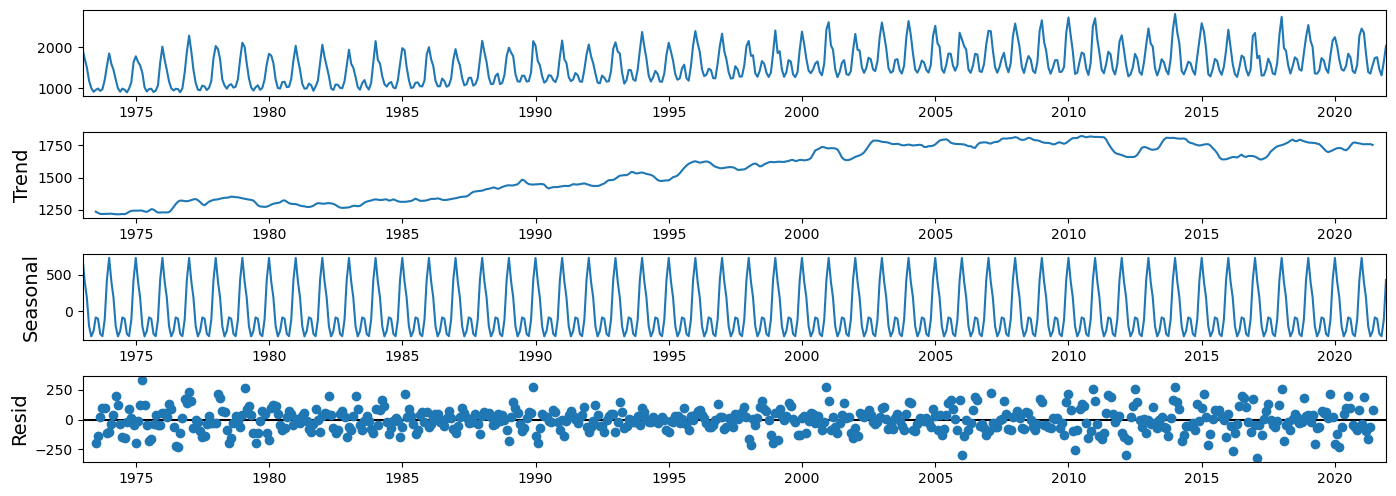

In [90]:
decomposed = seasonal_decompose(df)
decomposed.plot();

In [91]:
test.index

DatetimeIndex(['2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
      

In [92]:
def make_forecast(data, n, regressor, window=12):
    fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)
    forecaster = [
            ("deseasonalize", Deseasonalizer(sp=12, model="additive")),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1)))]
    if not isinstance(regressor, NaiveForecaster):
        reg = ("forecaster", make_reduction(
            regressor,
            strategy='recursive',
            window_length=window,
            scitype='tabular-regressor'))
        forecaster.append(reg)
        model = TransformedTargetForecaster(forecaster).fit(data.values)
        
    else:
        model = regressor.fit(data.values)
    
    predicted = pd.Series(
            model.predict(fh=fh).reshape(-1),
            index= test.index
                    )
    return predicted

In [93]:
make_reduction(lr)

RecursiveTabularRegressionForecaster(estimator=LinearRegression())

In [94]:
regressors = {
            'Naive Forecaster' : NaiveForecaster(strategy='mean', sp=12),
            'Linear Regression': LinearRegression(),
            'K-NN Regressor': KNeighborsRegressor(n_neighbors=5),
            'Extra Tree Regressor': ExtraTreesRegressor(),
            'Random Forest Regressor': RandomForestRegressor(),
            'Gradient Boosting Regressor': GradientBoostingRegressor()
            }

for k, reg in regressors.items():
    print(f'training {reg} ...')
    test[k] = make_forecast(train, len(test), regressor=reg , window=15)

In [95]:
test.shape

(88, 7)

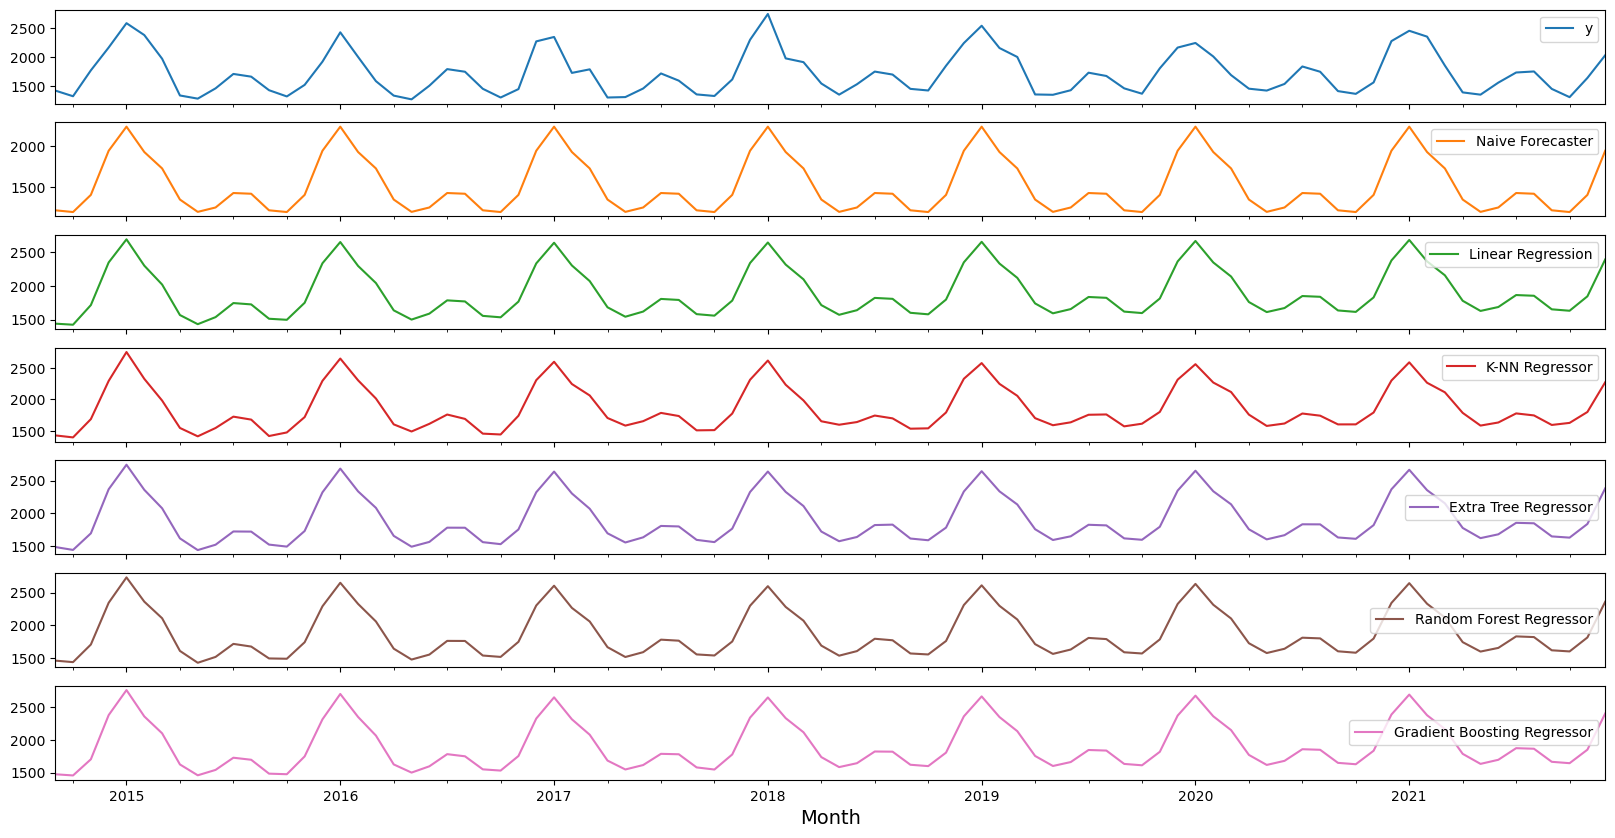

In [96]:
test.plot(subplots=True, figsize=(20, 10));plt.show()

<AxesSubplot: xlabel='Month'>

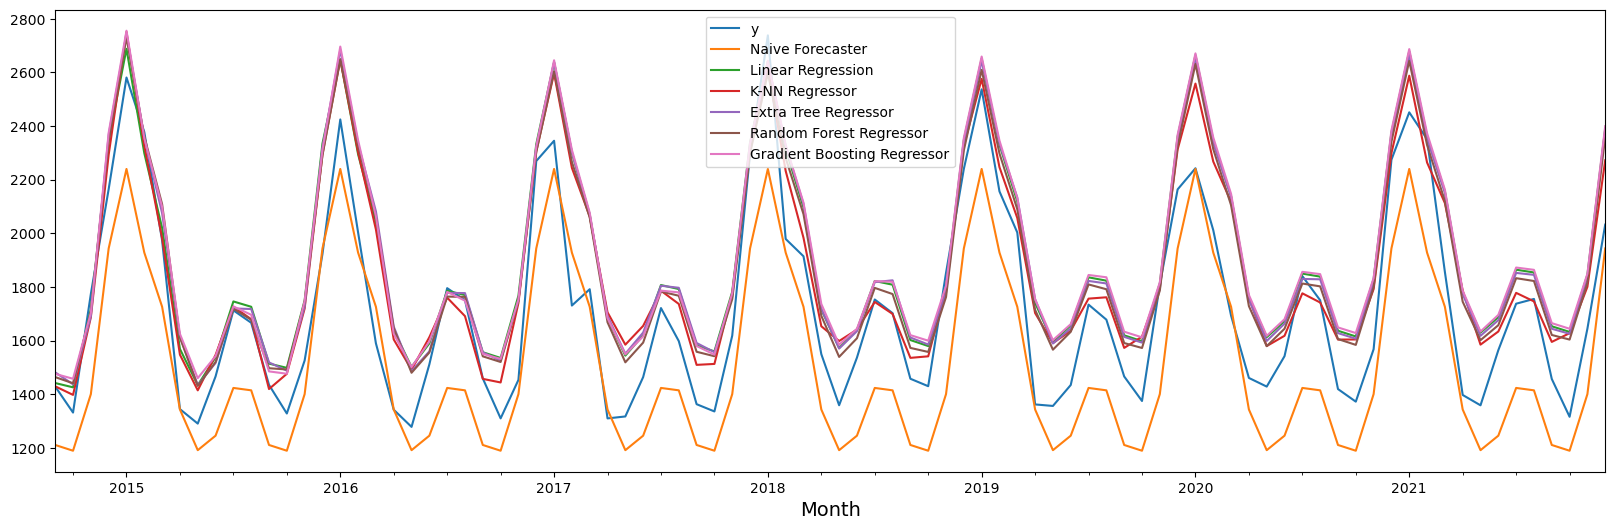

In [97]:
test.plot(subplots=False, figsize=(20, 6))

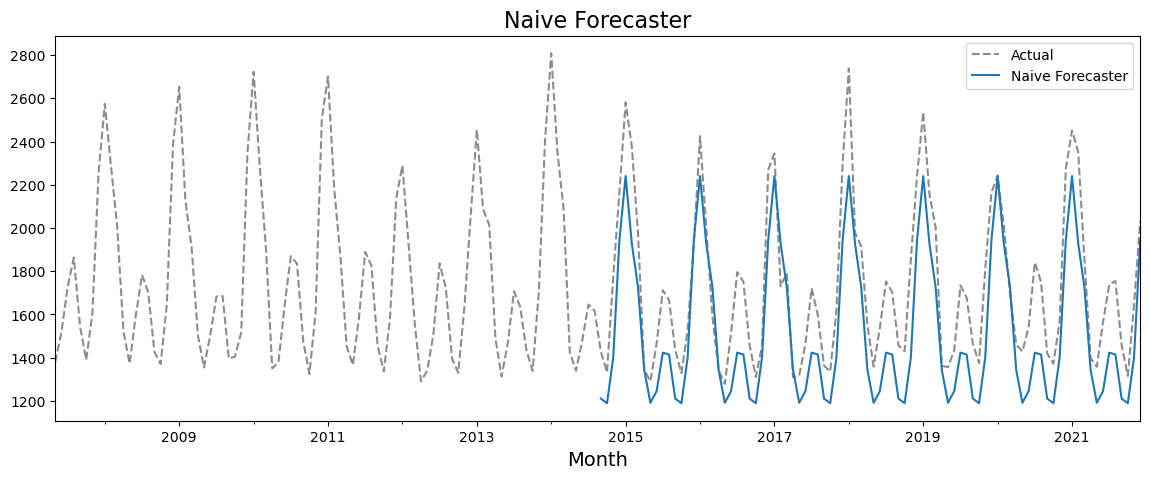

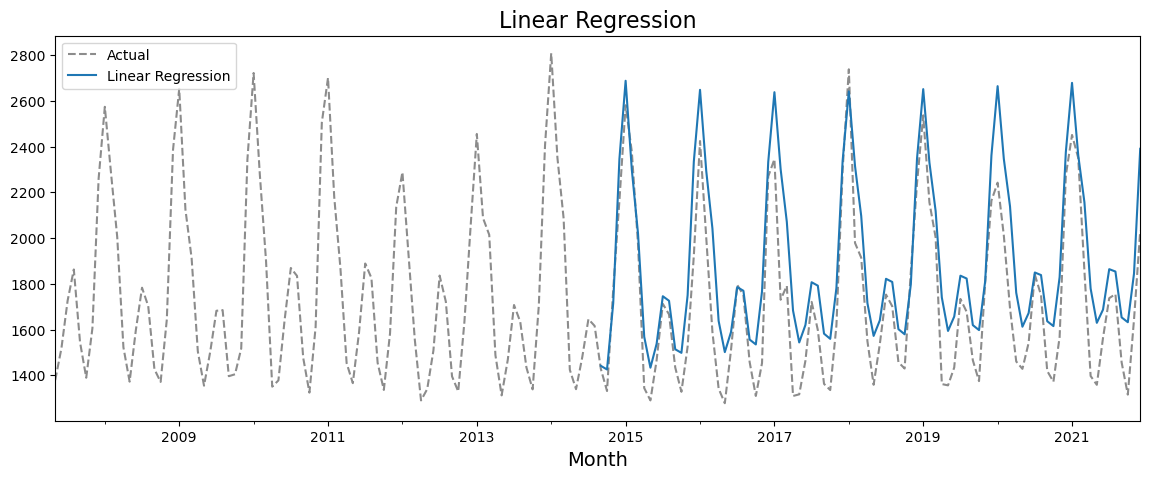

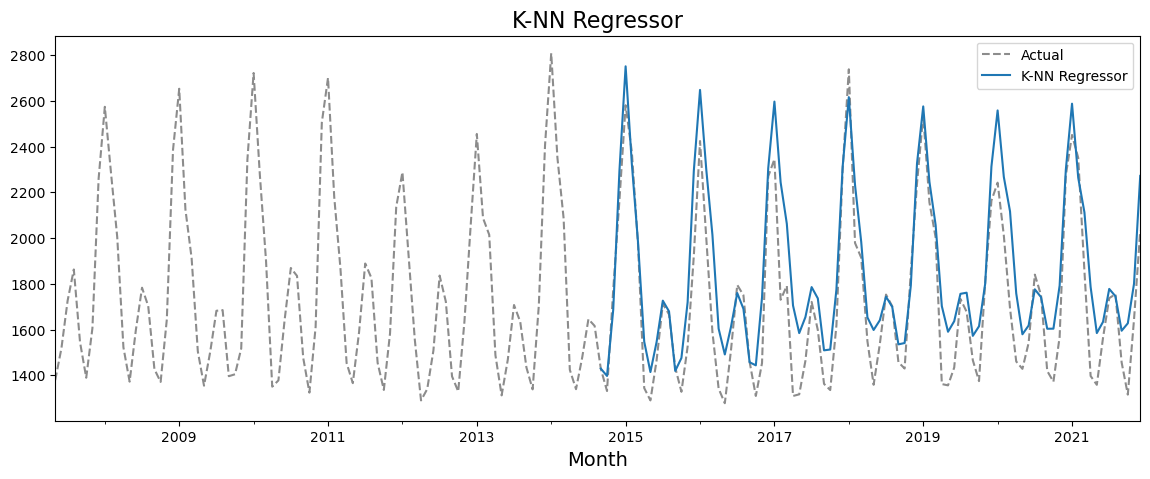

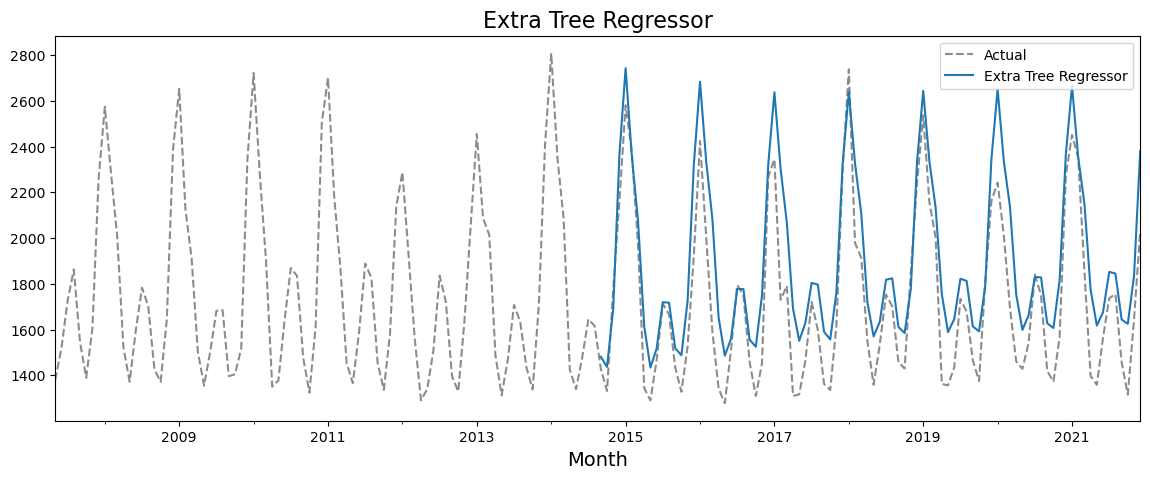

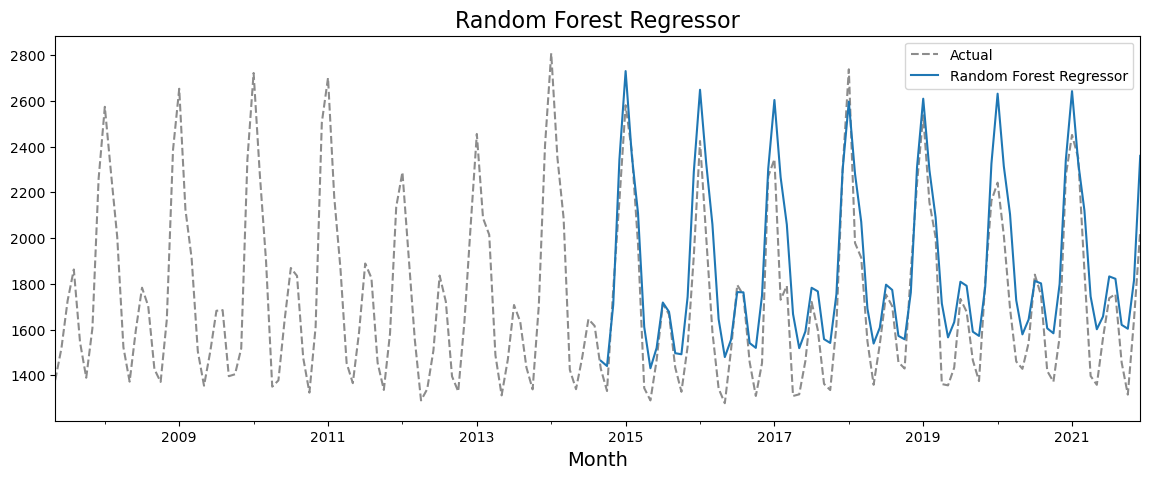

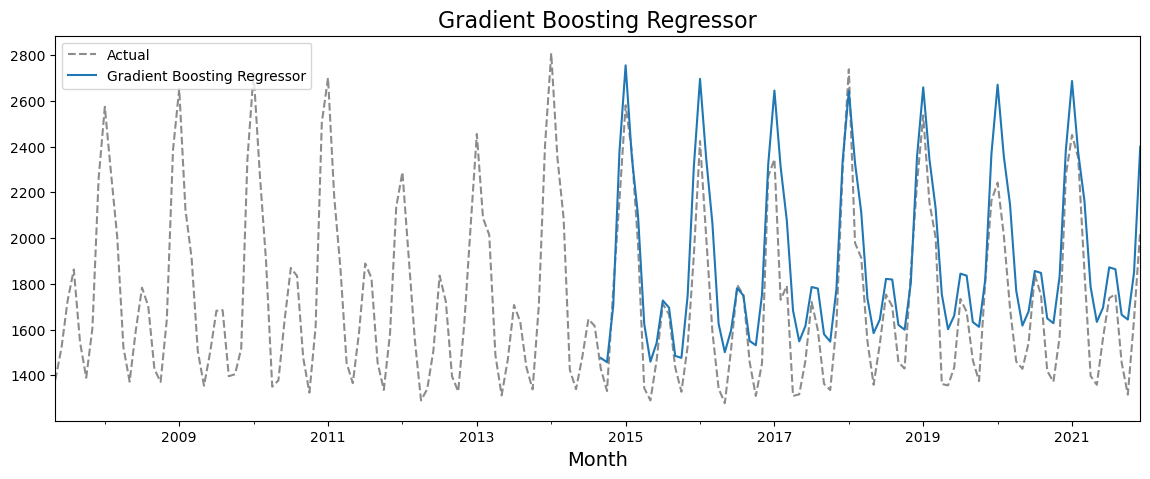

In [98]:
for i in test.iloc[: , 1:]:
    ax = df[-2*len(test):].plot(style='k--', alpha=0.45, title=i)
    test[i].plot(ax=ax)
    plt.legend(['Actual', i])
    plt.show()

In [99]:
test

y  Naive Forecaster  Linear Regression  K-NN Regressor  \
Month                                                                       
2014-09-01  1428.555       1210.663512        1441.612460     1429.364383   
2014-10-01  1331.478       1189.233073        1425.604618     1397.392401   
2014-11-01  1773.932       1400.315878        1715.650462     1686.999710   
2014-12-01  2164.807       1943.541073        2346.454781     2293.247940   
2015-01-01  2580.929       2239.992643        2687.958228     2751.156269   
2015-02-01  2377.381       1927.963810        2298.830022     2325.886884   
2015-03-01  1972.902       1725.951738        2019.790808     1981.479894   
2015-04-01  1344.384       1342.994690        1568.729094     1547.310713   
2015-05-01  1290.396       1191.250952        1433.508832     1414.379463   
2015-06-01  1466.241       1245.329429        1537.897266     1546.437888   
2015-07-01  1712.660       1423.348833        1745.882981     1726.594435   
2015-08-01  1666.388       1414.440881        1726.027071     1679.604502   
2015-09-01  1434.699       1210.663512        1513.966406     1419.242144   
2015-10-01  1328.016       1189.233073        1498.390225     1475.990844   
2015-11-01  1525.757       1400.315878        1750.131255     1719.524596   
2015-12-01  1922.859       1943.541073        2334.648723     2294.368098   
2016-01-01  2424.517       2239.992643        2648.355540     2647.937063   
2016-02-01  2003.172       1927.963810        2294.652728     2302.367084   
2016-03-01  1589.631       1725.951738        2042.118920     2014.419944   
2016-04-01  1342.110       1342.994690        1638.128676     1604.148746   
2016-05-01  1278.117       1191.250952        1501.596284     1491.322546   
2016-06-01  1511.270       1245.329429        1589.579428     1612.673773   
2016-07-01  1795.383       1423.348833        1785.794518     1760.043068   
2016-08-01  1750.524       1414.440881        1769.801534     1691.025883   
2016-09-01  1458.755       1210.663512        1556.467779     1457.147220   
2016-10-01  1309.835       1189.233073        1535.182377     1443.765500   
2016-11-01  1453.555       1400.315878        1767.281745     1740.488427   
2016-12-01  2269.472       1943.541073        2332.351021     2305.318417   
2017-01-01  2345.103       2239.992643        2638.017891     2596.933241   
2017-02-01  1730.556       1927.963810        2301.818699     2243.999208   
2017-03-01  1791.490       1725.951738        2070.940532     2062.546344   
2017-04-01  1309.744       1342.994690        1683.400769     1705.295083   
2017-05-01  1316.979       1191.250952        1543.869330     1584.697241   
2017-06-01  1463.766       1245.329429        1620.138786     1654.751099   
2017-07-01  1721.174       1423.348833        1807.024071     1785.879775   
2017-08-01  1598.033       1414.440881        1792.096382     1736.553555   
2017-09-01  1362.790       1210.663512        1582.201623     1509.370553   
2017-10-01  1335.691       1189.233073        1559.569560     1512.898692   
2017-11-01  1618.332       1400.315878        1782.194374     1775.488249   
2017-12-01  2296.680       1943.541073        2337.687769     2311.113196   
2018-01-01  2738.076       2239.992643        2641.489906     2616.404861   
2018-02-01  1978.829       1927.963810        2314.993196     2232.488974   
2018-03-01  1914.282       1725.951738        2096.604729     1983.244607   
2018-04-01  1549.317       1342.994690        1715.708572     1653.329601   
2018-05-01  1358.800       1191.250952        1572.459321     1598.308488   
2018-06-01  1536.406       1245.329429        1640.501117     1640.854600   
2018-07-01  1753.123       1423.348833        1822.068141     1743.933539   
2018-08-01  1702.151       1414.440881        1808.335511     1699.292687   
2018-09-01  1457.597       1210.663512        1601.902804     1535.490995   
2018-10-01  1429.831       1189.233073        1579.542984     1541.270606   
2018-11-01  185

In [100]:
def evaluate(df, train, sort_by='MASE'):
    evals = pd.DataFrame(index=['sMAPE', 'MAPE', 'RMSE'])
    y_truth = df['y']
    y_predicted = df.drop(columns=['y'])
    for p in y_predicted:
        evals.loc['sMAPE', p] = mape(y_truth, y_predicted[p], symmetric=True)
        evals.loc['MAPE', p] = mape(y_truth, y_predicted[p], symmetric=False)
        evals.loc['RMSE', p] = np.sqrt(mse(y_truth, y_predicted[p]))
        evals.loc['MASE', p] = mase(y_truth, y_predicted[p], y_train=train)
    return evals.T.sort_values(by=sort_by)
    

In [101]:
evaluate(test, train)

sMAPE      MAPE        RMSE      MASE
K-NN Regressor               0.088718  0.095485  192.449319  0.685551
Random Forest Regressor      0.095861  0.103105  202.013501  0.747107
Extra Tree Regressor         0.105301  0.113808  219.382462  0.825899
Linear Regression            0.105661  0.114187  219.063673  0.828132
Gradient Boosting Regressor  0.109251  0.118294  226.483574  0.860031
Naive Forecaster             0.133619  0.123643  242.222293  0.957688

In [102]:
evaluate(test, train, sort_by='RMSE')

sMAPE      MAPE        RMSE      MASE
K-NN Regressor               0.088718  0.095485  192.449319  0.685551
Random Forest Regressor      0.095861  0.103105  202.013501  0.747107
Linear Regression            0.105661  0.114187  219.063673  0.828132
Extra Tree Regressor         0.105301  0.113808  219.382462  0.825899
Gradient Boosting Regressor  0.109251  0.118294  226.483574  0.860031
Naive Forecaster             0.133619  0.123643  242.222293  0.957688

## There is more

In [103]:
from pmdarima import auto_arima
n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1)
arima = auto_arima(y=train, seasonal=True, m=12, suppress_warnings=True)

KeyboardInterrupt: 

In [ ]:
arima.summary()

In [ ]:
test['ARIMA'] = arima.predict(n)

In [ ]:
test.shape

In [ ]:
test.head()

In [ ]:
evaluate(test, train)

In [ ]:
ax = train.loc['2011':].plot(style='--', alpha=0.35)
test['ARIMA'].plot(ax=ax, style='k-.')
test['K-NN Regressor'].plot(ax=ax, style='k-o')
# test['Naive Forecaster'].plot(ax=ax, style='.-')
plt.legend(['train', 'ARIMA', 'KNN Regressor'])
#plt.savefig('../../../Packt-Time-Series-Cookbook/Chapters/Ch12/images/fig_12.14.png', bbox_inches='tight', dpi=600)

## How it Works

```python
make_reduction(estimator, 
               strategy='recursive', 
               window_length=10, 
               scitype='infer')
```

# Recipe 5. Optimizing a Machine Learning model with Hyperparameter Tuning

In [104]:
from sktime.forecasting.all import (
        ForecastingGridSearchCV, 
        SlidingWindowSplitter,
        MeanAbsolutePercentageError)

In [105]:
df = energy.copy()

In [106]:
train, test = split_data(df)

In [107]:
test.shape

(88, 1)

In [108]:
n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)
forecaster = TransformedTargetForecaster(
    [("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
     ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
     ("forecast",
            make_reduction(
                KNeighborsRegressor(),
                scitype="tabular-regressor",
                window_length=12,
                strategy="recursive",
            ), ),  ])

In [109]:
forecaster.fit(train.values)
test['KNN-Regressor'] = forecaster.predict(fh)

In [110]:
test.head()

y  KNN-Regressor
Month                              
2014-09-01  1428.555    1404.930420
2014-10-01  1331.478    1400.715430
2014-11-01  1773.932    1733.417657
2014-12-01  2164.807    2333.941613
2015-01-01  2580.929    2777.382750

In [111]:
evaluate(test, train)

sMAPE      MAPE        RMSE      MASE
KNN-Regressor  0.090378  0.097746  225.568315  0.751772

In [112]:
KNeighborsRegressor()

KNeighborsRegressor()

In [113]:
forecaster.get_params()

{'steps': [('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
  ('detrend', Detrender(forecaster=PolynomialTrendForecaster())),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                        window_length=12))],
 'deseasonalize': Deseasonalizer(model='multiplicative', sp=12),
 'detrend': Detrender(forecaster=PolynomialTrendForecaster()),
 'forecast': RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                      window_length=12),
 'deseasonalize__model': 'multiplicative',
 'deseasonalize__sp': 12,
 'detrend__forecaster': PolynomialTrendForecaster(),
 'detrend__model': 'additive',
 'detrend__forecaster__degree': 1,
 'detrend__forecaster__regressor': None,
 'detrend__forecaster__with_intercept': True,
 'forecast__estimator': KNeighborsRegressor(),
 'forecast__pooling': 'local',
 'forecast__transformers': None,
 'forecast__window_length': 12,
 'forecast__estimator_

In [114]:
forecaster.get_params().keys()

dict_keys(['steps', 'deseasonalize', 'detrend', 'forecast', 'deseasonalize__model', 'deseasonalize__sp', 'detrend__forecaster', 'detrend__model', 'detrend__forecaster__degree', 'detrend__forecaster__regressor', 'detrend__forecaster__with_intercept', 'forecast__estimator', 'forecast__pooling', 'forecast__transformers', 'forecast__window_length', 'forecast__estimator__algorithm', 'forecast__estimator__leaf_size', 'forecast__estimator__metric', 'forecast__estimator__metric_params', 'forecast__estimator__n_jobs', 'forecast__estimator__n_neighbors', 'forecast__estimator__p', 'forecast__estimator__weights'])

In [115]:
# example grid search space
hyperparams_grid = {
    "forecast__estimator__n_neighbors": [i for i in range(3,11)],
    "deseasonalize__model": ['multiplicative', 'additive'],
    "forecast__estimator__p": [1,2]
}

In [116]:
cv = SlidingWindowSplitter(window_length=int(len(df) * 0.70), fh=fh)
smape = MeanAbsolutePercentageError(symmetric=True)

grid_csv = ForecastingGridSearchCV(
    forecaster, 
    strategy="refit", 
    cv=cv,
    param_grid=hyperparams_grid, 
    scoring=smape,
    return_n_best_forecasters=1,
    verbose=1
)

In [117]:
grid_csv.cv

SlidingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
            86, 87, 88],
           dtype='int64', is_relative=True),
                      window_length=411)

In [118]:
fh

ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
            86, 87, 88],
           dtype='int64', is_relative=True)

In [119]:
grid_csv.fit(train.values, fh=fh)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
            86, 87, 88],
           dtype='int64', is_relat...
                                                                       Detrender(forecaster=PolynomialTrendForecaster())),
                                                                      ('forecast',
                                                                       RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                                                                                            window_length=12))]),
                        param_grid={'deseasonalize__model': ['multiplicative',
                                                             'additive'],
                                    'forecast__estimator__n_neighbors': [3, 4,
                                                                         5, 6,
                                                                         7, 8,
                                                                         9,
                                                                         10],
                                    'forecast__estimator__p': [1, 2]},
                        scoring=MeanAbsolutePercentageError(symmetric=True),
                        verbose=1)

In [120]:
grid_csv.best_forecaster_

TransformedTargetForecaster(steps=[('deseasonalize', Deseasonalizer(sp=12)),
                                   ('detrend',
                                    Detrender(forecaster=PolynomialTrendForecaster())),
                                   ('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=7),
                                                                         window_length=12))])

In [121]:
grid_csv.best_params_

{'deseasonalize__model': 'additive',
 'forecast__estimator__n_neighbors': 7,
 'forecast__estimator__p': 2}

In [122]:
grid_csv.cv_results_

mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
0                                0.068065       0.074285        0.110159   
1                                0.066450       0.063523        0.113962   
2                                0.065952       0.072348        0.107689   
3                                0.064853       0.073749        0.110914   
4                                0.064658       0.073954        0.111433   
5                                0.062486       0.073388        0.110718   
6                                0.064220       0.075923        0.112949   
7                                0.065216       0.073998        0.100624   
8                                0.066626       0.074918        0.103450   
9                                0.065606       0.074030        0.113903   
10                               0.065828       0.063104        0.117568   
11                               0.066243       0.065897        0.103448   
12                               0.067104       0.072676        0.113962   
13                               0.065111       0.073491        0.114635   
14                               0.066061       0.077919        0.112953   
15                               0.066096       0.074646        0.110671   
16                               0.068791       0.069319        0.115428   
17                               0.063391       0.070643        0.112359   
18                               0.065888       0.077661        0.117045   
19                               0.062623       0.072134        0.115996   
20                               0.064386       0.077292        0.106468   
21                               0.066547       0.073208        0.112290   
22                               0.068606       0.074858        0.107818   
23                               0.066154       0.072673        0.109334   
24                               0.069438       0.071539        0.111943   
25                               0.062401       0.073445        0.111988   
26                               0.065195       0.077070        0.114544   
27                               0.062890       0.075973        0.114473   
28                               0.068173       0.073362        0.121322   
29                               0.063770       0.072323        0.110684   
30                               0.065876       0.076537        0.114079   
31                               0.064710       0.071637        0.102757   

                                               params  \
0   {'deseasonalize__model': 'multiplicative', 'fo...   
1   {'deseasonalize__model': 'multiplicative', 'fo...   
2   {'deseasonalize__model': 'multiplicative', 'fo...   
3   {'deseasonalize__model': 'multiplicative', 'fo...   
4   {'deseasonalize__model': 'multiplicative', 'fo...   
5   {'deseasonalize__model': 'multiplicative', 'fo...   
6   {'deseasonalize__model': 'multiplicative', 'fo...   
7   {'deseasonalize__model': 'multiplicative', 'fo...   
8   {'deseasonalize__model': 'multiplicative', 'fo...   
9   {'deseasonalize__model': 'multiplicative', 'fo...   
10  {'deseasonalize__model': 'multiplicative', 'fo...   
11  {'deseasonalize__model': 'multiplicative', 'fo...   
12  {'deseasonalize__model': 'multiplicative', 'fo...   
13  {'deseasonalize__model': 'multiplicative', 'fo...   
14  {'deseasonalize__model': 'multiplicative', 'fo...   
15  {'deseasonalize__model': 'multiplicative', 'fo...   
16  {'deseasonalize__model': 'additive', 'forecast...   
17  {'deseasonalize__model': 'additive', 'forecast...   
18  {'deseasonalize__model': 'additive', 'forecast...   
19  {'deseasonalize__model': 'additive', 'forecast...   
20  {'deseasonalize__model': 'additive', 'forecast...   
21  {'deseasonalize__model': 'additive', 'forecast...   
22  {'deseasonalize__model': 'additive', 'forecast...   
23  {'deseasonalize__model': 'additive', 'forecast...   
24  {'deseasonalize__model': 'additive', 'forecast...   
25  {'deseaso

In [123]:
test['KNN_optimized'] = grid_csv.predict(fh)

In [124]:
evaluate(test, train)

sMAPE      MAPE        RMSE      MASE
KNN_optimized  0.088823  0.095325  188.102334  0.684741
KNN-Regressor  0.090378  0.097746  225.568315  0.751772

In [125]:
grid_csv.cv_results_

mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
0                                0.068065       0.074285        0.110159   
1                                0.066450       0.063523        0.113962   
2                                0.065952       0.072348        0.107689   
3                                0.064853       0.073749        0.110914   
4                                0.064658       0.073954        0.111433   
5                                0.062486       0.073388        0.110718   
6                                0.064220       0.075923        0.112949   
7                                0.065216       0.073998        0.100624   
8                                0.066626       0.074918        0.103450   
9                                0.065606       0.074030        0.113903   
10                               0.065828       0.063104        0.117568   
11                               0.066243       0.065897        0.103448   
12                               0.067104       0.072676        0.113962   
13                               0.065111       0.073491        0.114635   
14                               0.066061       0.077919        0.112953   
15                               0.066096       0.074646        0.110671   
16                               0.068791       0.069319        0.115428   
17                               0.063391       0.070643        0.112359   
18                               0.065888       0.077661        0.117045   
19                               0.062623       0.072134        0.115996   
20                               0.064386       0.077292        0.106468   
21                               0.066547       0.073208        0.112290   
22                               0.068606       0.074858        0.107818   
23                               0.066154       0.072673        0.109334   
24                               0.069438       0.071539        0.111943   
25                               0.062401       0.073445        0.111988   
26                               0.065195       0.077070        0.114544   
27                               0.062890       0.075973        0.114473   
28                               0.068173       0.073362        0.121322   
29                               0.063770       0.072323        0.110684   
30                               0.065876       0.076537        0.114079   
31                               0.064710       0.071637        0.102757   

                                               params  \
0   {'deseasonalize__model': 'multiplicative', 'fo...   
1   {'deseasonalize__model': 'multiplicative', 'fo...   
2   {'deseasonalize__model': 'multiplicative', 'fo...   
3   {'deseasonalize__model': 'multiplicative', 'fo...   
4   {'deseasonalize__model': 'multiplicative', 'fo...   
5   {'deseasonalize__model': 'multiplicative', 'fo...   
6   {'deseasonalize__model': 'multiplicative', 'fo...   
7   {'deseasonalize__model': 'multiplicative', 'fo...   
8   {'deseasonalize__model': 'multiplicative', 'fo...   
9   {'deseasonalize__model': 'multiplicative', 'fo...   
10  {'deseasonalize__model': 'multiplicative', 'fo...   
11  {'deseasonalize__model': 'multiplicative', 'fo...   
12  {'deseasonalize__model': 'multiplicative', 'fo...   
13  {'deseasonalize__model': 'multiplicative', 'fo...   
14  {'deseasonalize__model': 'multiplicative', 'fo...   
15  {'deseasonalize__model': 'multiplicative', 'fo...   
16  {'deseasonalize__model': 'additive', 'forecast...   
17  {'deseasonalize__model': 'additive', 'forecast...   
18  {'deseasonalize__model': 'additive', 'forecast...   
19  {'deseasonalize__model': 'additive', 'forecast...   
20  {'deseasonalize__model': 'additive', 'forecast...   
21  {'deseasonalize__model': 'additive', 'forecast...   
22  {'deseasonalize__model': 'additive', 'forecast...   
23  {'deseasonalize__model': 'additive', 'forecast...   
24  {'deseasonalize__model': 'additive', 'forecast...   
25  {'deseaso

In [126]:
model = grid_csv.best_forecaster_

In [127]:
model.get_params() 

{'steps': [('deseasonalize', Deseasonalizer(sp=12)),
  ('detrend', Detrender(forecaster=PolynomialTrendForecaster())),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=7),
                                        window_length=12))],
 'deseasonalize': Deseasonalizer(sp=12),
 'detrend': Detrender(forecaster=PolynomialTrendForecaster()),
 'forecast': RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=7),
                                      window_length=12),
 'deseasonalize__model': 'additive',
 'deseasonalize__sp': 12,
 'detrend__forecaster': PolynomialTrendForecaster(),
 'detrend__model': 'additive',
 'detrend__forecaster__degree': 1,
 'detrend__forecaster__regressor': None,
 'detrend__forecaster__with_intercept': True,
 'forecast__estimator': KNeighborsRegressor(n_neighbors=7),
 'forecast__pooling': 'local',
 'forecast__transformers': None,
 'forecast__window_length': 12,
 'forecast__estimator__algorithm': 'a

# Recipe 6. Multivariate Forecasting and Ensemble Learning with sktime

In [128]:
from sktime.forecasting.all import EnsembleForecaster
from sklearn.svm import SVR
from sktime.transformations.series.detrend import ConditionalDeseasonalizer
from sktime.datasets import load_macroeconomic

In [129]:
load_macroeconomic().shape

(203, 12)

In [130]:
econ = load_macroeconomic()
cols = ['realgdp','realdpi','tbilrate', 'unemp', 'infl']
econ_df = econ[cols]

In [131]:
econ_df.shape

(203, 5)

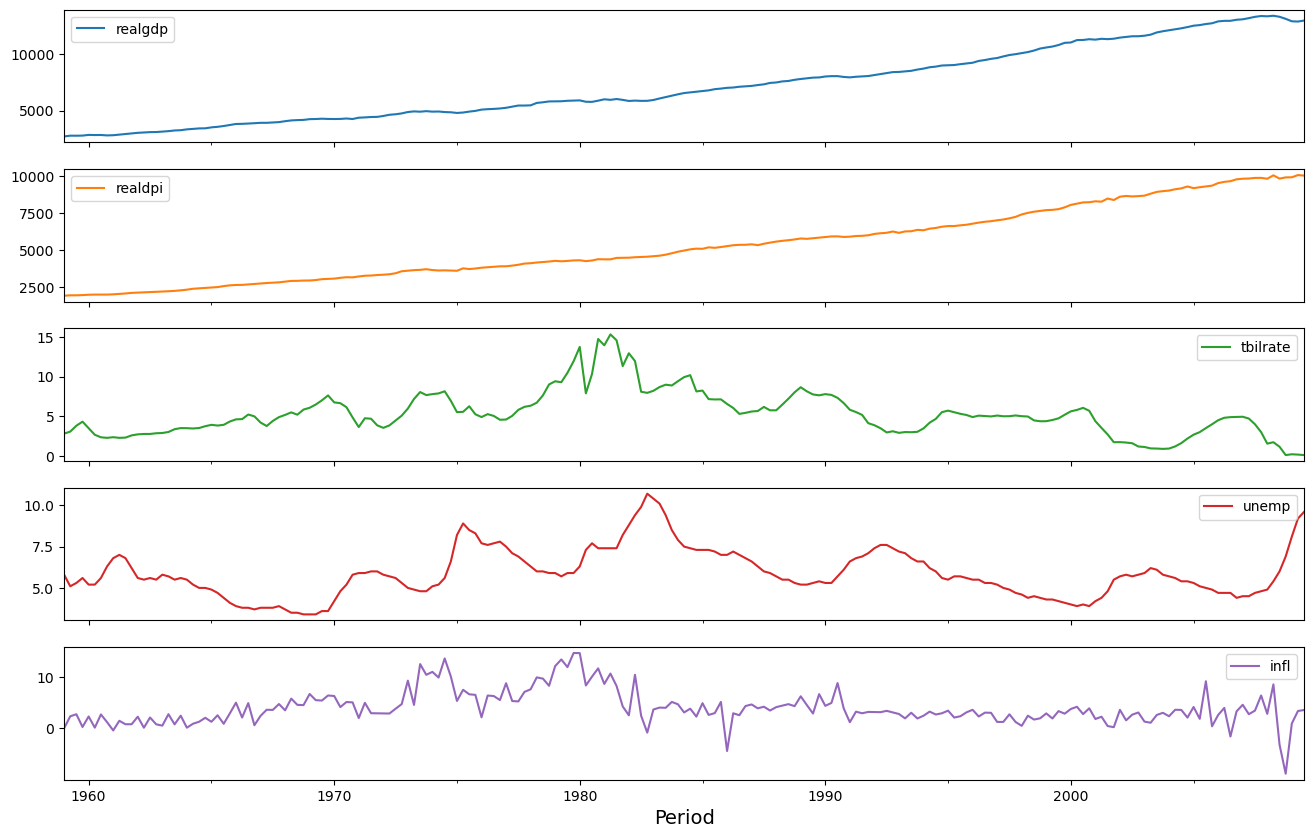

In [132]:
econ_df.plot(subplots=True, figsize=(16, 10));plt.show()

## How to do it

In [133]:
econ_df.head()

realgdp  realdpi  tbilrate  unemp  infl
Period                                          
1959Q1  2710.349   1886.9      2.82    5.8  0.00
1959Q2  2778.801   1919.7      3.08    5.1  2.34
1959Q3  2775.488   1916.4      3.82    5.3  2.74
1959Q4  2785.204   1931.3      4.33    5.6  0.27
1960Q1  2847.699   1955.5      3.50    5.2  2.31

In [134]:
cond_deseason = ConditionalDeseasonalizer(sp=4)
detrend = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
for col in econ_df:
    econ_df[col] = cond_deseason.fit_transform(econ_df[col])
    econ_df[col] = detrend.fit_transform(econ_df[col])

In [135]:
y = econ_df['unemp']
exog = econ_df.drop(columns=['unemp'])

In [136]:
len(econ_df)*0.1

20.3

In [137]:
test_size = 0.1
y_train, y_test = split_data(y, test_split=test_size)
exog_train, exog_test = split_data(exog, test_split=test_size)

In [138]:
regressors = [
    ("LinearRegression", make_reduction(LinearRegression())),
    ("RandomForest", make_reduction(RandomForestRegressor())),
    ("SupportVectorRegressor", make_reduction(SVR())),
    ("GradientBoosting", make_reduction(GradientBoostingRegressor()))]

In [139]:
ensemble = EnsembleForecaster(regressors)
naive = NaiveForecaster()

In [140]:
ensemble.fit(y=y_train, X=exog_train)
naive.fit(y=y_train, X=exog_train)

NaiveForecaster()

In [141]:
fh = ForecastingHorizon(y_test.index, is_relative=None)

y_hat = pd.DataFrame(y_test).rename(columns={'unemp': 'test'})
y_hat['EnsembleForecaster'] = ensemble.predict(fh=fh, X=exog_test)
y_hat['NaiveForecaster'] = naive.predict(fh=fh, X=exog_test)

In [142]:
y_hat.rename(columns={'test':'y'}, inplace=True)

In [143]:
evaluate(y_hat, y_train)

sMAPE      MAPE      RMSE      MASE
EnsembleForecaster  1.221899  0.994426  1.342011  4.470704
NaiveForecaster     0.946033  2.490779  1.537844  4.522654

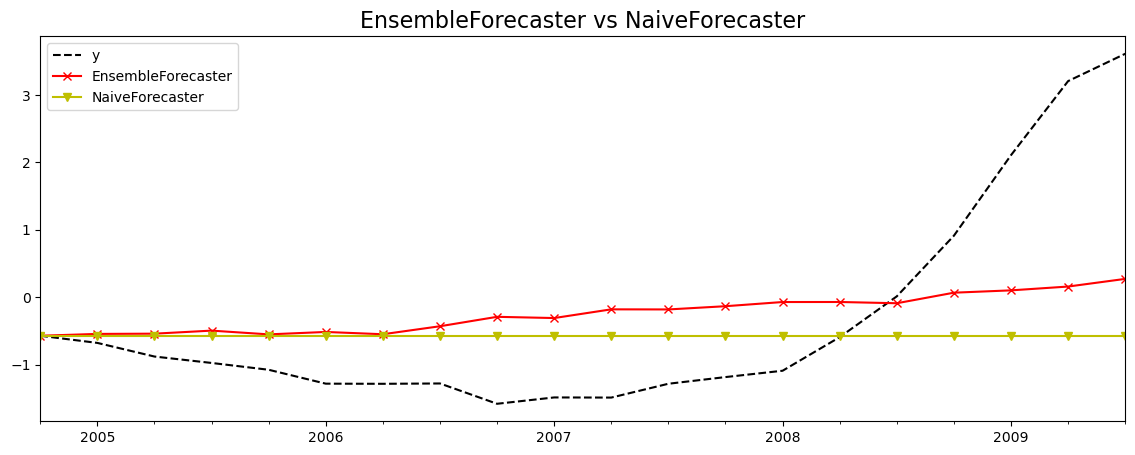

In [144]:
styles = ['k--','rx-','yv-']
for col, s in zip(y_hat, styles):
    y_hat[col].plot(style=s, label=col, 
                    title='EnsembleForecaster vs NaiveForecaster')
plt.legend()
#plt.savefig('../../../Packt-Time-Series-Cookbook/Chapters/Ch12/images/fig_12.18.png', bbox_inches='tight', dpi=600)

## There is more

In [145]:
regressors

[('LinearRegression',
  RecursiveTabularRegressionForecaster(estimator=LinearRegression())),
 ('RandomForest',
  RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())),
 ('SupportVectorRegressor',
  RecursiveTabularRegressionForecaster(estimator=SVR())),
 ('GradientBoosting',
  RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor()))]

In [146]:
from sktime.forecasting.compose import AutoEnsembleForecaster

auto = AutoEnsembleForecaster(forecasters=regressors,
                             method='feature-importance')
auto.fit(y=y_train, X=exog_train)

AutoEnsembleForecaster(forecasters=[('LinearRegression',
                                     RecursiveTabularRegressionForecaster(estimator=LinearRegression())),
                                    ('RandomForest',
                                     RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())),
                                    ('SupportVectorRegressor',
                                     RecursiveTabularRegressionForecaster(estimator=SVR())),
                                    ('GradientBoosting',
                                     RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor()))])

In [147]:
auto.weights_

[0.06286083509471674,
 0.4250860279228808,
 0.24014133837985852,
 0.2719117986025439]

In [148]:
y_hat['AutoEnsembleForecaster'] = auto.predict(fh=fh, X=exog_test)

In [149]:
evaluate(y_hat, y_train)

sMAPE      MAPE      RMSE      MASE
EnsembleForecaster      1.221899  0.994426  1.342011  4.470704
NaiveForecaster         0.946033  2.490779  1.537844  4.522654
AutoEnsembleForecaster  1.402246  0.938779  1.445285  4.850064